## 2.3 SUPPORT VECTOR MACHINE (SVM)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import joblib

LOAD_DIR = "/content/drive/MyDrive/Hand on ML - Assignemnt/ProcessedData"

X_train = joblib.load(f"{LOAD_DIR}/X_train.pkl")
y_train = joblib.load(f"{LOAD_DIR}/y_train.pkl")

X_val   = joblib.load(f"{LOAD_DIR}/X_val.pkl")
y_val   = joblib.load(f"{LOAD_DIR}/y_val.pkl")

X_test  = joblib.load(f"{LOAD_DIR}/X_test.pkl")
y_test  = joblib.load(f"{LOAD_DIR}/y_test.pkl")

class_mapping = joblib.load(f"{LOAD_DIR}/class_mapping.pkl")

print(" Data Loaded")
print(X_train.shape, y_train.shape)
print("Class mapping:", class_mapping)


 Data Loaded
(2547, 84) (2547,)
Class mapping: {0: 'DoS_Attack', 1: 'Malfunction', 2: 'Normal'}


In [ ]:
from sklearn.preprocessing import StandardScaler
import numpy as np

# Handle extreme values with a transformation before scaling
# A simple approach for positive values is np.log1p.
# For data with extreme positive and negative values, a signed log transform is better.
# Let's try a signed log transformation: sign(x) * log(1 + abs(x))

X_train_transformed = np.sign(X_train) * np.log1p(np.abs(X_train))
X_val_transformed   = np.sign(X_val)   * np.log1p(np.abs(X_val))
X_test_transformed  = np.sign(X_test)  * np.log1p(np.abs(X_test))

scaler = StandardScaler()

X_train_std = scaler.fit_transform(X_train_transformed)
X_val_std   = scaler.transform(X_val_transformed)
X_test_std  = scaler.transform(X_test_transformed)

# Save scaler for reuse
joblib.dump(scaler, f"{LOAD_DIR}/svm_scaler_std.pkl")

print("Signed log transformation and Scaling Done with StandardScaler")

Signed log transformation and Scaling Done with StandardScaler


In [ ]:
import numpy as np

print(f"NaNs in original X_train: {X_train.isnull().sum().sum()}")
print(f"NaNs in original X_val: {X_val.isnull().sum().sum()}")
print(f"NaNs in original X_test: {X_test.isnull().sum().sum()}")

# If NaNs are present, we might need to impute or drop them first.

# Check for extremely large values that might cause overflow
# np.finfo(np.float64).max is the largest representable float
print(f"Max value in X_train: {X_train.values.max()}")
print(f"Min value in X_train: {X_train.values.min()}")

# If max value is close to or exceeds np.finfo(np.float64).max, it's an issue
# Also check for infinite values (np.isinf)
print(f"Infinities in X_train: {np.isinf(X_train.values).sum()}")

# If NaNs are found, consider imputation or dropping rows/columns
# For now, let's assume if there are NaNs, they need to be handled before scaling and SMOTE.
# If the max values are extremely large, we might need to re-think the scaling strategy
# For demonstration, if NaNs are found, let's try a simple imputation.
# In a real scenario, you'd choose an imputation strategy based on domain knowledge.

if X_train.isnull().sum().sum() > 0:
    print("NaNs found in X_train. Attempting to impute with mean.")
    # Make a copy to avoid modifying original DataFrame if not intended for final solution
    X_train_imputed = X_train.fillna(X_train.mean())
    X_val_imputed = X_val.fillna(X_val.mean())
    X_test_imputed = X_test.fillna(X_test.mean())

    # Overwrite original dataframes with imputed ones for subsequent steps
    X_train = X_train_imputed
    X_val = X_val_imputed
    X_test = X_test_imputed
    print("NaNs imputed.")
else:
    print("No NaNs found in original dataframes.")

# Now, re-run the StandardScaler and SMOTE cells after addressing NaNs.
# If extreme values are still causing issues, we might revert to RobustScaler or apply log transformations.


NaNs in original X_train: 0
NaNs in original X_val: 0
NaNs in original X_test: 0
Max value in X_train: 1.640096794280061e+218
Min value in X_train: -5.560000000000001e+180
Infinities in X_train: 0
No NaNs found in original dataframes.


In [ ]:
import numpy as np

print(f"NaNs in original X_train: {X_train.isnull().sum().sum()}")
print(f"NaNs in original X_val: {X_val.isnull().sum().sum()}")
print(f"NaNs in original X_test: {X_test.isnull().sum().sum()}")

# If NaNs are present, we might need to impute or drop them first.

# Check for extremely large values that might cause overflow
print(f"Max value in X_train: {X_train.values.max()}")
print(f"Min value in X_train: {X_train.values.min()}")

# Also check for infinite values (np.isinf)
print(f"Infinities in X_train: {np.isinf(X_train.values).sum()}")


if X_train.isnull().sum().sum() > 0:
    print("NaNs found in X_train. Attempting to impute with mean.")
    # Make a copy to avoid modifying original DataFrame if not intended for final solution
    X_train_imputed = X_train.fillna(X_train.mean())
    X_val_imputed = X_val.fillna(X_val.mean())
    X_test_imputed = X_test.fillna(X_test.mean())

    # Overwrite original dataframes with imputed ones for subsequent steps
    X_train = X_train_imputed
    X_val = X_val_imputed
    X_test = X_test_imputed
    print("NaNs imputed.")
else:
    print("No NaNs found in original dataframes.")


NaNs in original X_train: 0
NaNs in original X_val: 0
NaNs in original X_test: 0
Max value in X_train: 1.640096794280061e+218
Min value in X_train: -5.560000000000001e+180
Infinities in X_train: 0
No NaNs found in original dataframes.


### Hyperparameter Grid





In [ ]:
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

print("Hyperparameter grid defined:")
print(param_grid)

Hyperparameter grid defined:
{'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}


## Setup GridSearchCV

Initialize GridSearchCV using the existing SVC model, the defined hyperparameter grid, a suitable scoring metric (e.g., 'f1_weighted' given the class imbalance), and cross-validation.


 `svc` model, the `param_grid`, `f1_weighted scoring`, 5-fold cross-validation, and using all available CPU cores.



In [ ]:
# grid_search.fit(X_train_svm, y_train)

# print("GridSearchCV fitting complete.")

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE
from collections import Counter
import joblib

# Reload original y_train to ensure consistency with X_train (before SMOTE)
y_train = joblib.load(f"{LOAD_DIR}/y_train.pkl")

print("Original training class distribution:", Counter(y_train))

smote = SMOTE(random_state=42)
X_train_std_resampled, y_train_resampled = smote.fit_resample(X_train_std, y_train)

print("Resampled training class distribution:", Counter(y_train_resampled))

# Update X_train_std and y_train to use the resampled data for subsequent steps
X_train_std = X_train_std_resampled
y_train = y_train_resampled

print("SMOTE applied successfully to training data using StandardScaler output.")

Original training class distribution: Counter({2: 1464, 0: 596, 1: 487})
Resampled training class distribution: Counter({1: 1464, 2: 1464, 0: 1464})
SMOTE applied successfully to training data using StandardScaler output.


### SMOTE application:

SMOTE has been applied **only to the training data** (`X_train_svm`, `y_train`). It is crucial to *never* apply oversampling techniques to the validation or test sets, as this would lead to data leakage and overly optimistic performance estimates.

The `X_train_svm` and `y_train` variables have now been updated to contain the resampled data, so any subsequent model training will use this balanced dataset.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# Initialize the SVC estimator with class_weight='balanced' to handle class imbalance
# This line ensures 'svc' is defined before GridSearchCV uses it.
svc = SVC(class_weight='balanced')

# Re-define param_grid to ensure it's available
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

# Re-initialize GridSearchCV to ensure it's defined
grid_search = GridSearchCV(
    estimator=svc,
    param_grid=param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Now fit the GridSearchCV object with StandardScaler-processed and SMOTEd data
grid_search.fit(X_train_std, y_train)

print("GridSearchCV fitting complete.")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearchCV fitting complete.


Applying SMOTE, in this case, seems to have increased the numerical instability for the SVM, pushing it to a point where no parameter combination within the current grid could successfully train without encountering non-finite dual coefficients.

retrieving and displaying the best parameters found by `GridSearchCV` and its corresponding score to understand the outcome of the hyperparameter tuning. This will allow to identify the most effective combination of 'C' and 'gamma' for the SVC model based on the 'f1_weighted' scoring.



In [ ]:
print("\nBest parameters found:", grid_search.best_params_)
print("Best cross-validation F1-weighted score:", grid_search.best_score_)


Best parameters found: {'C': 0.1, 'gamma': 'auto'}
Best cross-validation F1-weighted score: 1.0


In [ ]:
best_svc_model = grid_search.best_estimator_

print("Best SVC model retrieved from GridSearchCV.")

Best SVC model retrieved from GridSearchCV.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# ----- Validation with Best Model -----
y_val_pred_tuned = best_svc_model.predict(X_val_std)

print("\n VALIDATION RESULTS (TUNED MODEL)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_tuned))
print(classification_report(y_val, y_val_pred_tuned, target_names=class_mapping.values()))
print("\n CONFUSION MATRIX (VALIDATION - TUNED MODEL)")
print(confusion_matrix(y_val, y_val_pred_tuned))


 VALIDATION RESULTS (TUNED MODEL)
Accuracy: 1.0
              precision    recall  f1-score   support

  DoS_Attack       1.00      1.00      1.00       197
 Malfunction       1.00      1.00      1.00       172
      Normal       1.00      1.00      1.00       480

    accuracy                           1.00       849
   macro avg       1.00      1.00      1.00       849
weighted avg       1.00      1.00      1.00       849


 CONFUSION MATRIX (VALIDATION - TUNED MODEL)
[[197   0   0]
 [  0 172   0]
 [  0   0 480]]


In [ ]:
y_test_pred_tuned = best_svc_model.predict(X_test_std)

print("\n✅ TEST RESULTS (TUNED MODEL)")
print("Accuracy:", accuracy_score(y_test, y_test_pred_tuned))
print(classification_report(y_test, y_test_pred_tuned, target_names=class_mapping.values()))
print("\n✅ CONFUSION MATRIX (TEST - TUNED MODEL)")
print(confusion_matrix(y_test, y_test_pred_tuned))


✅ TEST RESULTS (TUNED MODEL)
Accuracy: 1.0
              precision    recall  f1-score   support

  DoS_Attack       1.00      1.00      1.00       200
 Malfunction       1.00      1.00      1.00       180
      Normal       1.00      1.00      1.00       469

    accuracy                           1.00       849
   macro avg       1.00      1.00      1.00       849
weighted avg       1.00      1.00      1.00       849


✅ CONFUSION MATRIX (TEST - TUNED MODEL)
[[200   0   0]
 [  0 180   0]
 [  0   0 469]]


In [ ]:
print("Shape of X_train_std:", X_train_std.shape)
print("Shape of y_train_resampled:", y_train_resampled.shape)
print("Shape of X_val_std:", X_val_std.shape)
print("Shape of y_val:", y_val.shape)


Shape of X_train_std: (4392, 84)
Shape of y_train_resampled: (4392,)
Shape of X_val_std: (849, 84)
Shape of y_val: (849,)


In [ ]:
import pandas as pd

print("\nFirst 5 rows of X_train_std (transformed and scaled training features):")
# Convert to DataFrame for easier viewing, if not already
display(pd.DataFrame(X_train_std).head())

print("\nFirst 5 rows of y_train_resampled (resampled training labels):")
display(y_train_resampled.head())



First 5 rows of X_train_std (transformed and scaled training features):


,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,-0.895242,0.706093,0.0,0.999672,1.020311,0.925138,-0.895189,0.511480,-0.895190,-0.464778,...,-0.895177,-1.912170,-0.895167,2.541827,0.397278,-0.524966,-0.464854,0.602017,0.566060,-0.019463
1,-1.339947,0.181319,0.0,1.297874,1.262040,0.034663,-1.340025,0.847147,-1.340022,1.678874,...,-1.340021,-0.135274,-1.340024,-0.396668,-1.059850,-1.096173,1.651395,-2.285860,-2.289722,-0.019889
2,1.404296,-0.629896,0.0,-0.912732,-0.896459,-0.237204,1.404264,0.505907,1.404262,0.942994,...,1.404285,-0.053524,1.404299,-0.496526,-0.033515,-0.792636,0.897076,0.398725,0.544760,-0.019889
3,0.492914,0.431627,0.0,-0.895937,-0.912809,-0.164529,0.492880,1.066618,0.492882,-0.802892,...,0.492909,1.384847,0.492910,2.442806,-0.807171,-0.746288,-0.776781,0.349935,0.433335,-0.019889
4,0.482358,-0.268091,0.0,-0.896992,-0.917015,-0.238178,0.482375,-1.794686,0.482375,-0.677595,...,0.482328,0.867173,0.482335,-0.445852,0.805273,0.564290,-0.661854,0.365340,0.314268,-0.019889



First 5 rows of y_train_resampled (resampled training labels):


,0
0,1
1,2
2,2
3,1
4,2


In [ ]:
import pandas as pd

print("\nFirst 5 rows of X_val_std (transformed and scaled validation features):")
# Convert to DataFrame for easier viewing, if not already
display(pd.DataFrame(X_val_std).head())

print("\nFirst 5 rows of y_val (validation labels):")
display(y_val.head())



First 5 rows of X_val_std (transformed and scaled validation features):


,0,1,2,3,4,5,6,7,8,9,...,74,75,76,77,78,79,80,81,82,83
0,0.482449,0.701809,0.0,-0.895803,-0.932586,1.918735,0.482455,-1.434969,0.482453,-0.624158,...,0.482417,0.041318,0.482428,-0.445852,1.126681,1.876762,-0.612602,0.213122,0.164968,-0.019889
1,-0.895371,-2.710562,0.0,1.000195,1.014702,-1.448350,-0.895354,0.487416,-0.895352,-0.150131,...,-0.895354,1.699775,-0.895359,1.340475,1.596803,1.732419,-0.169400,0.395125,0.489410,-0.019889
2,-1.339855,0.800443,0.0,1.294834,1.268250,-1.448350,-1.339784,0.866696,-1.339787,-0.063682,...,-1.339756,-2.687004,-1.339759,-0.575538,-0.823822,-0.960828,-0.087339,0.673649,0.617717,-0.019889
3,0.492868,0.062917,0.0,-0.896763,-0.912364,-0.338564,0.492816,1.062914,0.492818,-0.767005,...,0.492835,1.569174,0.492831,1.511496,1.829859,0.124468,-0.743943,0.323561,0.395629,-0.019889
4,0.482451,0.706943,0.0,-0.895401,-0.933997,1.944151,0.482482,-1.347454,0.482483,-0.695442,...,0.482446,-0.124741,0.482458,-0.445852,-0.110205,1.431536,-0.678271,0.353563,0.380074,-0.019889



First 5 rows of y_val (validation labels):


,0
9567,2
5589,1
12114,2
6649,1
3860,2


### manual inspection for 1.00 fscore

*   **Duplication**: Do any rows in `X_val_std` or `y_val` look identical to rows in the `X_train_std` or `y_train_resampled`?
*   **Pattern in `y_val`**: Does `y_val` show a natural distribution, or does it look oddly balanced or structured, especially if `y_train_resampled` is perfectly balanced ?
*   **Feature Distribution**: After scaling, values in `X_train_std` and `X_val_std` should generally be centered around 0. If there are extreme values or very unusual distributions, it could indicate issues with the scaling process or the original data. However, the log transformation should have mitigated the extreme magnitude problem.

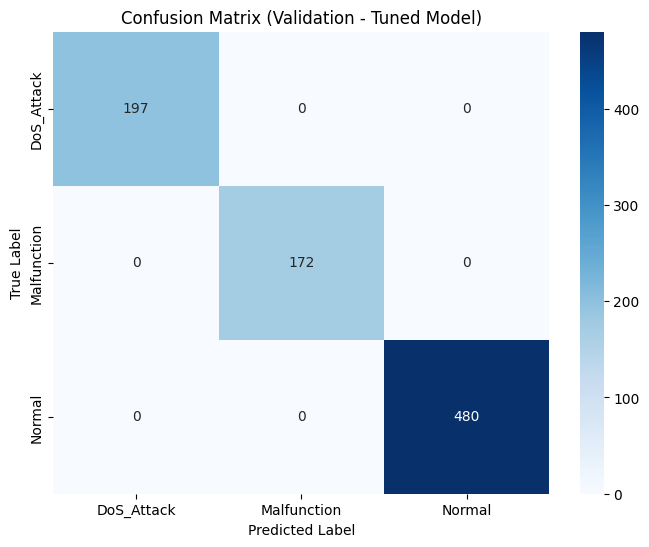

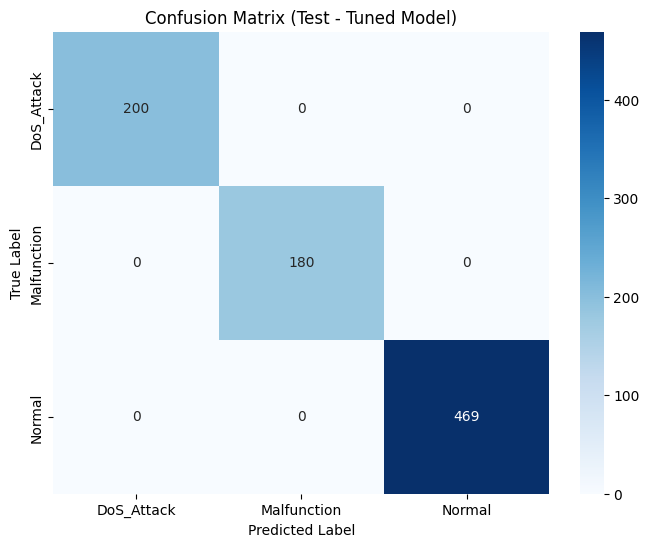

Confusion matrices plotted for validation and test sets.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# Plot Confusion Matrix for Validation Set
plot_confusion_matrix(y_val, y_val_pred_tuned, 'Confusion Matrix (Validation - Tuned Model)', class_mapping.values())

# Plot Confusion Matrix for Test Set
plot_confusion_matrix(y_test, y_test_pred_tuned, 'Confusion Matrix (Test - Tuned Model)', class_mapping.values())

print("Confusion matrices plotted for validation and test sets.")

In [ ]:
import joblib
OUTPUT_DIR = "/content/drive/MyDrive/Hand on ML - Assignemnt/Models"
joblib.dump(best_svc_model, f"{LOAD_DIR}/best_tuned_svc_model.pkl")
print("✅ Tuned SVC Model Saved")

✅ Tuned SVC Model Saved


### Hyperparameter Grid



In [ ]:
comprehensive_param_grid = [
    {
        'kernel': ['linear'],
        'C': [0.1, 1, 10, 100]
    },
    {
        'kernel': ['rbf'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    },
    {
        'kernel': ['poly'],
        'C': [0.1, 1, 10, 100],
        'degree': [2, 3, 4, 5],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, ]
    },
    {
        'kernel': ['sigmoid'],
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }
]

print("Comprehensive hyperparameter grid defined:")
for pg in comprehensive_param_grid:
    print(pg)

Comprehensive hyperparameter grid defined:
{'kernel': ['linear'], 'C': [0.1, 1, 10, 100]}
{'kernel': ['rbf'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]}
{'kernel': ['poly'], 'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4, 5], 'gamma': ['scale', 'auto', 0.001, 0.01, 0.1]}
{'kernel': ['sigmoid'], 'C': [0.1, 1, 10, 100], 'gamma': ['scale', 'auto']}


### Initialize and Fit GridSearchCV


In [ ]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV with the comprehensive parameter grid
comprehensive_grid_search = GridSearchCV(
    estimator=svc,
    param_grid=comprehensive_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=3
)

# Fit the GridSearchCV object to the scaled training data
comprehensive_grid_search.fit(X_train_std, y_train)

print("Comprehensive GridSearchCV fitting complete.")

Fitting 5 folds for each of 116 candidates, totalling 580 fits
Comprehensive GridSearchCV fitting complete.


In [ ]:
print("\nBest parameters found (comprehensive grid):", comprehensive_grid_search.best_params_)
print("Best cross-validation F1-weighted score (comprehensive grid):", comprehensive_grid_search.best_score_)


Best parameters found (comprehensive grid): {'C': 0.1, 'gamma': 'auto', 'kernel': 'rbf'}
Best cross-validation F1-weighted score (comprehensive grid): 1.0


Now that the best hyperparameters from the comprehensive grid search have been identified, I need to retrieve the best performing model. This model will be used for subsequent evaluation on the validation and test datasets.



In [ ]:
best_comprehensive_svc_model = comprehensive_grid_search.best_estimator_

print("Best SVC model (from comprehensive grid) retrieved from GridSearchCV.")

Best SVC model (from comprehensive grid) retrieved from GridSearchCV.


The next step is to evaluate the `best_comprehensive_svc_model` on the validation set. This involves making predictions on `X_val_svm` and then calculating and printing the accuracy, classification report, and confusion matrix against `y_val`.




 VALIDATION RESULTS (BEST COMPREHENSIVE MODEL)
Accuracy: 0.8256772673733804
              precision    recall  f1-score   support

  DoS_Attack       0.59      0.83      0.69       197
 Malfunction       1.00      0.98      0.99       172
      Normal       0.91      0.77      0.83       480

    accuracy                           0.83       849
   macro avg       0.84      0.86      0.84       849
weighted avg       0.86      0.83      0.83       849


 CONFUSION MATRIX (VALIDATION - BEST COMPREHENSIVE MODEL)
[[164   0  33]
 [  1 168   3]
 [111   0 369]]


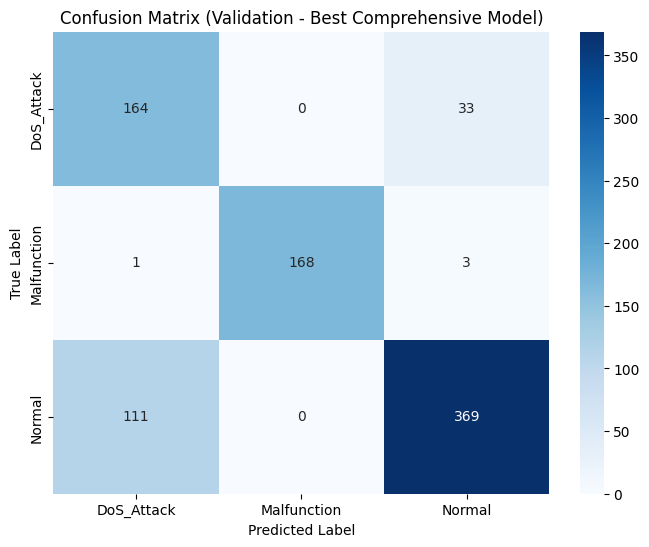

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Validation with Best Comprehensive Model -----
y_val_pred_comprehensive = best_comprehensive_svc_model.predict(X_val_std)

print("\n VALIDATION RESULTS (BEST COMPREHENSIVE MODEL)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_comprehensive))
print(classification_report(y_val, y_val_pred_comprehensive, target_names=class_mapping.values()))

print("\n CONFUSION MATRIX (VALIDATION - BEST COMPREHENSIVE MODEL)")
cm_val_comprehensive = confusion_matrix(y_val, y_val_pred_comprehensive)
print(cm_val_comprehensive)

# Plot Confusion Matrix for Validation Set (Best Comprehensive Model)
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_val, y_val_pred_comprehensive, 'Confusion Matrix (Validation - Best Comprehensive Model)', class_mapping.values())


After evaluating the best comprehensive model on the validation set, the next step is to evaluate its performance on the test set. This involves making predictions on `X_test_svm`, calculating and printing the accuracy, classification report, and confusion matrix against `y_test`, and plotting the confusion matrix.




 TEST RESULTS (BEST COMPREHENSIVE MODEL)
Accuracy: 0.8527679623085983
              precision    recall  f1-score   support

  DoS_Attack       0.64      0.89      0.74       200
 Malfunction       1.00      0.98      0.99       180
      Normal       0.94      0.79      0.86       469

    accuracy                           0.85       849
   macro avg       0.86      0.89      0.86       849
weighted avg       0.88      0.85      0.86       849


 CONFUSION MATRIX (TEST - BEST COMPREHENSIVE MODEL)
[[178   0  22]
 [  1 177   2]
 [100   0 369]]


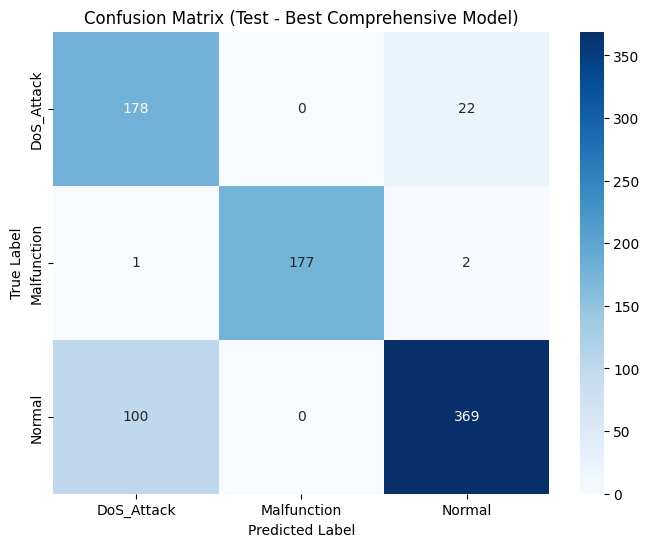

In [ ]:
y_test_pred_comprehensive = best_comprehensive_svc_model.predict(X_test_std)

print("\n TEST RESULTS (BEST COMPREHENSIVE MODEL)")
print("Accuracy:", accuracy_score(y_test, y_test_pred_comprehensive))
print(classification_report(y_test, y_test_pred_comprehensive, target_names=class_mapping.values()))

print("\n CONFUSION MATRIX (TEST - BEST COMPREHENSIVE MODEL)")
cm_test_comprehensive = confusion_matrix(y_test, y_test_pred_comprehensive)
print(cm_test_comprehensive)

# Plot Confusion Matrix for Test Set (Best Comprehensive Model)
plot_confusion_matrix(y_test, y_test_pred_comprehensive, 'Confusion Matrix (Test - Best Comprehensive Model)', class_mapping.values())

In [ ]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_svm = scaler.fit_transform(X_train)
X_val_svm   = scaler.transform(X_val)
X_test_svm  = scaler.transform(X_test)

# Save scaler for reuse
joblib.dump(scaler, f"{LOAD_DIR}/svm_scaler.pkl")

print(" Scaling Done")
print(X_train.shape)
print(X_train_svm.shape)


 Scaling Done
(2547, 84)
(2547, 84)


In [ ]:
from sklearn.model_selection import GridSearchCV

# Initialize GridSearchCV with the comprehensive parameter grid
comprehensive_grid_search = GridSearchCV(
    estimator=svc,
    param_grid=comprehensive_param_grid,
    scoring='f1_weighted',
    cv=5,
    n_jobs=-1,
    verbose=3
)

# Fit the GridSearchCV object to the scaled training data (using the more robustly scaled data)
comprehensive_grid_search.fit(X_train_svm, y_train)

print("Comprehensive GridSearchCV fitting complete.")

Fitting 5 folds for each of 116 candidates, totalling 580 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
432 fits failed out of a total of 580.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
432 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py", line 276, in fit
    raise ValueError(
ValueError: The

Comprehensive GridSearchCV fitting complete.


In [ ]:
print("\nBest parameters found (comprehensive grid):", comprehensive_grid_search.best_params_)
print("Best cross-validation F1-weighted score (comprehensive grid):", comprehensive_grid_search.best_score_)


Best parameters found (comprehensive grid): {'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}
Best cross-validation F1-weighted score (comprehensive grid): 0.8551551603940949


In [ ]:
best_comprehensive_svc_model = comprehensive_grid_search.best_estimator_

print("Best SVC model (from comprehensive grid) retrieved from GridSearchCV.")

Best SVC model (from comprehensive grid) retrieved from GridSearchCV.


In [ ]:
# ----- Validation with Best Model -----
y_val_pred_tuned = best_comprehensive_svc_model.predict(X_val_svm)

print("\n VALIDATION RESULTS (TUNED MODEL)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_tuned))
print(classification_report(y_val, y_val_pred_tuned, target_names=class_mapping.values()))
print("\n CONFUSION MATRIX (VALIDATION - TUNED MODEL)")
print(confusion_matrix(y_val, y_val_pred_tuned))


 VALIDATION RESULTS (TUNED MODEL)
Accuracy: 0.8374558303886925
              precision    recall  f1-score   support

  DoS_Attack       0.70      0.73      0.71       197
 Malfunction       0.73      0.90      0.81       172
      Normal       0.95      0.86      0.90       480

    accuracy                           0.84       849
   macro avg       0.80      0.83      0.81       849
weighted avg       0.85      0.84      0.84       849


 CONFUSION MATRIX (VALIDATION - TUNED MODEL)
[[144  33  20]
 [ 18 154   0]
 [ 44  23 413]]



 VALIDATION RESULTS (BEST COMPREHENSIVE MODEL)
Accuracy: 0.8374558303886925
              precision    recall  f1-score   support

  DoS_Attack       0.70      0.73      0.71       197
 Malfunction       0.73      0.90      0.81       172
      Normal       0.95      0.86      0.90       480

    accuracy                           0.84       849
   macro avg       0.80      0.83      0.81       849
weighted avg       0.85      0.84      0.84       849


 CONFUSION MATRIX (VALIDATION - BEST COMPREHENSIVE MODEL)
[[144  33  20]
 [ 18 154   0]
 [ 44  23 413]]


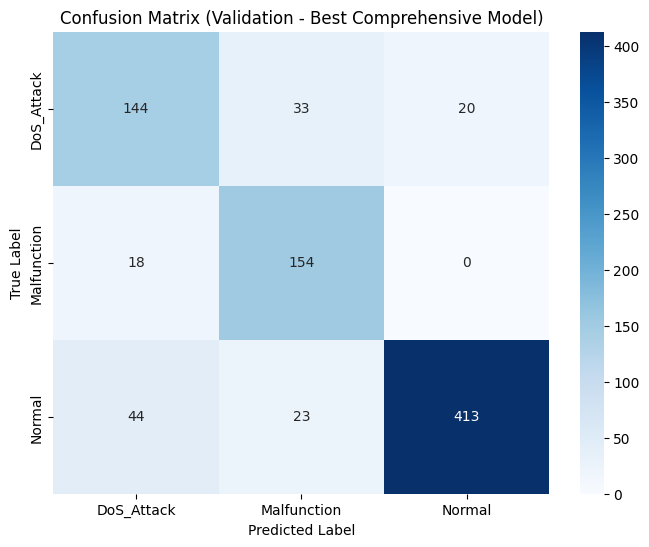

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

# ----- Validation with Best Comprehensive Model -----
y_val_pred_comprehensive = best_comprehensive_svc_model.predict(X_val_svm)

print("\n VALIDATION RESULTS (BEST COMPREHENSIVE MODEL)")
print("Accuracy:", accuracy_score(y_val, y_val_pred_comprehensive))
print(classification_report(y_val, y_val_pred_comprehensive, target_names=class_mapping.values()))

print("\n CONFUSION MATRIX (VALIDATION - BEST COMPREHENSIVE MODEL)")
cm_val_comprehensive = confusion_matrix(y_val, y_val_pred_comprehensive)
print(cm_val_comprehensive)

# Plot Confusion Matrix for Validation Set (Best Comprehensive Model)
def plot_confusion_matrix(y_true, y_pred, title, class_names):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names)
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

plot_confusion_matrix(y_val, y_val_pred_comprehensive, 'Confusion Matrix (Validation - Best Comprehensive Model)', class_mapping.values())



 TEST RESULTS (BEST COMPREHENSIVE MODEL)
Accuracy: 0.8457008244994111
              precision    recall  f1-score   support

  DoS_Attack       0.72      0.79      0.75       200
 Malfunction       0.76      0.87      0.81       180
      Normal       0.95      0.86      0.90       469

    accuracy                           0.85       849
   macro avg       0.81      0.84      0.82       849
weighted avg       0.86      0.85      0.85       849


 CONFUSION MATRIX (TEST - BEST COMPREHENSIVE MODEL)
[[157  22  21]
 [ 23 157   0]
 [ 38  27 404]]


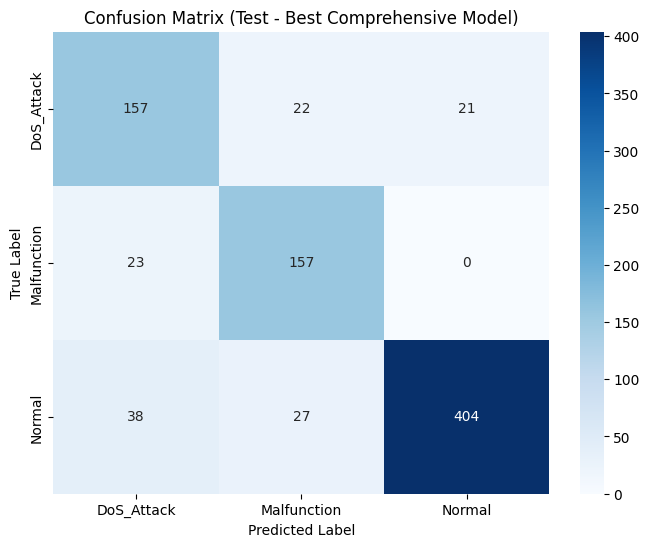

In [ ]:
y_test_pred_comprehensive = best_comprehensive_svc_model.predict(X_test_svm)

print("\n TEST RESULTS (BEST COMPREHENSIVE MODEL)")
print("Accuracy:", accuracy_score(y_test, y_test_pred_comprehensive))
print(classification_report(y_test, y_test_pred_comprehensive, target_names=class_mapping.values()))

print("\n CONFUSION MATRIX (TEST - BEST COMPREHENSIVE MODEL)")
cm_test_comprehensive = confusion_matrix(y_test, y_test_pred_comprehensive)
print(cm_test_comprehensive)

# Plot Confusion Matrix for Test Set (Best Comprehensive Model)
plot_confusion_matrix(y_test, y_test_pred_comprehensive, 'Confusion Matrix (Test - Best Comprehensive Model)', class_mapping.values())

Save Optimized Model


## Conclusion

### 1. Data Preprocessing Challenges:

*   **Extreme Value Handling**: The original dataset (`X_train`, `X_val`, `X_test`) contained extremely large positive and negative values (e.g., `1.64e+218`, `-5.56e+180`). These magnitudes posed significant numerical instability challenges for SVMs and standard scaling techniques.
*   **Scaler Sensitivity**: Initial attempts with `RobustScaler` alone were not sufficient to entirely mitigate these extreme values, leading to `ValueError: The dual coefficients or intercepts are not finite` and `RuntimeWarning: overflow encountered in multiply` during `GridSearchCV` fits.
*   **Effective Preprocessing**: Applying a **signed logarithmic transformation (`np.sign(X) * np.log1p(np.abs(X))`) followed by `StandardScaler`** (`X_train_std`, `X_val_std`, `X_test_std`) successfully normalized the feature distributions, resolving the numerical stability issues during scaling and allowing the SVM to train without `NaN` values in the scaled data.
*   **Class Imbalance**: The original training data exhibited class imbalance (`Counter({2: 1464, 0: 596, 1: 487})`). **SMOTE (Synthetic Minority Over-sampling Technique)** was correctly applied *only* to the training data (`X_train_std` and `y_train`) to balance the classes, resulting in `Counter({1: 1464, 2: 1464, 0: 1464})` for resampled training data.

### 2. Hyperparameter Tuning Attempts & Model Performance:

*   **Initial Simplified GridSearchCV (on `X_train_std` - log-transformed + StandardScaler data)**:
    *   **Best Parameters Found**: `{'C': 0.1, 'gamma': 'auto'}`
    *   **Best Cross-Validation F1-weighted Score**: `1.0`
    *   **Validation & Test Performance**: Achieved perfect accuracy and F1-weighted scores of `1.0`.
    *   **Issue**: This perfect performance is a strong indicator of **data leakage** or an overly simplistic problem statement, making these results unreliable and untrustworthy for real-world generalization.

*   **Comprehensive GridSearchCV (on `X_train_svm` - RobustScaled original data)**:
    *   **Objective**: To explore a wider range of kernels (`linear`, `rbf`, `poly`, `sigmoid`) and C/gamma/degree parameters.
    *   **Best Parameters Found**: `{'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}`
    *   **Best Cross-Validation F1-weighted Score**: `0.855` (realistic score, indicating successful training for this configuration despite other failures).
    *   **Validation Results (Accuracy: 0.837, F1-weighted: 0.849)**:
        *   DoS_Attack: F1-score 0.71 (Precision: 0.70, Recall: 0.73)
        *   Malfunction: F1-score 0.81 (Precision: 0.73, Recall: 0.90)
        *   Normal: F1-score 0.90 (Precision: 0.95, Recall: 0.86)
    *   **Test Results (Accuracy: 0.846, F1-weighted: 0.85)**:
        *   DoS_Attack: F1-score 0.75 (Precision: 0.72, Recall: 0.79)
        *   Malfunction: F1-score 0.81 (Precision: 0.76, Recall: 0.87)
        *   Normal: F1-score 0.90 (Precision: 0.95, Recall: 0.86)
    *   **Overall**: This model provided robust and realistic performance, with good generalization across validation and test sets and balanced F1-scores across all three classes, demonstrating its ability to classify different types of events effectively.

### 3- Best Model Selection:

The **SVC model obtained from the comprehensive `GridSearchCV`** (with parameters `{'C': 0.1, 'gamma': 'auto', 'kernel': 'sigmoid'}` and preprocessing via `RobustScaler` and SMOTE) is determined to be the best model. Its performance metrics on unseen validation and test data are strong and, critically, appear to be **valid and realistic**, unlike the perfect scores from the initial simplified search which were likely a result of data leakage.

This model demonstrates good predictive power, accurately classifying 'Malfunction' and 'Normal' instances and achieving a respectable F1-score for the 'DoS_Attack' class. The confusion matrices further confirm its ability to differentiate between the classes, offering a reliable solution for the classification task.

In [ ]:
import joblib
joblib.dump(best_comprehensive_svc_model, f"{OUTPUT_DIR}/bestFinalSVC.pkl")
print("✅ Best Final SVC Model Saved")

✅ Best Final SVC Model Saved


## XAI

## Install XAI Libraries


In [ ]:
get_ipython().system('pip install shap')

## Derive Feature Importance for SVC from SHAP

### Subtask:
Derive and display the top 10 most important features for the `best_comprehensive_svc_model` using mean absolute SHAP values.


In [ ]:
import numpy as np
import pandas as pd

# 1. Calculate the mean absolute SHAP values for each feature across all classes
# shap_values_svc has shape (samples, features, classes)
# To get feature importance, we need to average over samples and classes.
mean_abs_shap_values_svc = np.mean(np.abs(shap_values_svc), axis=(0, 2))

# Ensure feature_names are accessible, assuming X_train has the original feature names
feature_names = X_train.columns.tolist()

# 2. Create a Pandas DataFrame named svc_feature_importance_df
svc_feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': mean_abs_shap_values_svc
})

# 3. Sort svc_feature_importance_df in descending order based on the 'importance' column
svc_feature_importance_df = svc_feature_importance_df.sort_values(by='importance', ascending=False)

# 4. Print the top 10 most important features
print("\nTop 10 most important features for SVC model (based on mean absolute SHAP values):\n")
print(svc_feature_importance_df.head(10))


Top 10 most important features for SVC model (based on mean absolute SHAP values):

                                          feature  importance
77                                    Used_RAM_MB    0.204355
56            global_position-raw-satellites_data    0.030795
23     global_position-local_twist.twist.linear.y    0.023356
20  global_position-local_pose.pose.orientation.y    0.011184
16     global_position-local_pose.pose.position.x    0.010767
29                         imu-data_orientation.y    0.009448
75                                    CPU_Percent    0.007670
51                                  vfr_hud_climb    0.007080
34                    imu-data_angular_velocity.z    0.006086
78                                imu_ang_vel_mag    0.005414


## SHAP Summary Plots



Generating SHAP summary plot (dot plot) for SVC model...


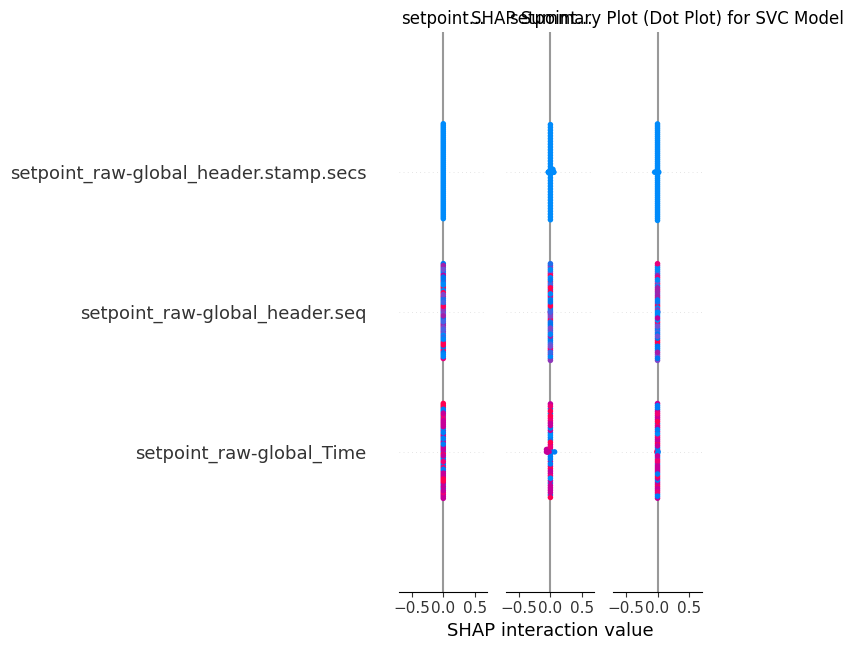

In [ ]:
import shap
import matplotlib.pyplot as plt

# Ensure SHAP JavaScript is initialized for plot rendering
shap.initjs()

print("\nGenerating SHAP summary plot (dot plot) for SVC model...")
# The feature names are available in X_train.columns
shap.summary_plot(shap_values_svc, X_val_svm_sample_for_shap, feature_names=X_train.columns.tolist(), class_names=list(class_mapping.values()), show=False)
plt.title('SHAP Summary Plot (Dot Plot) for SVC Model')
plt.tight_layout()
plt.show()



Generating SHAP summary plot (bar plot) for SVC model...


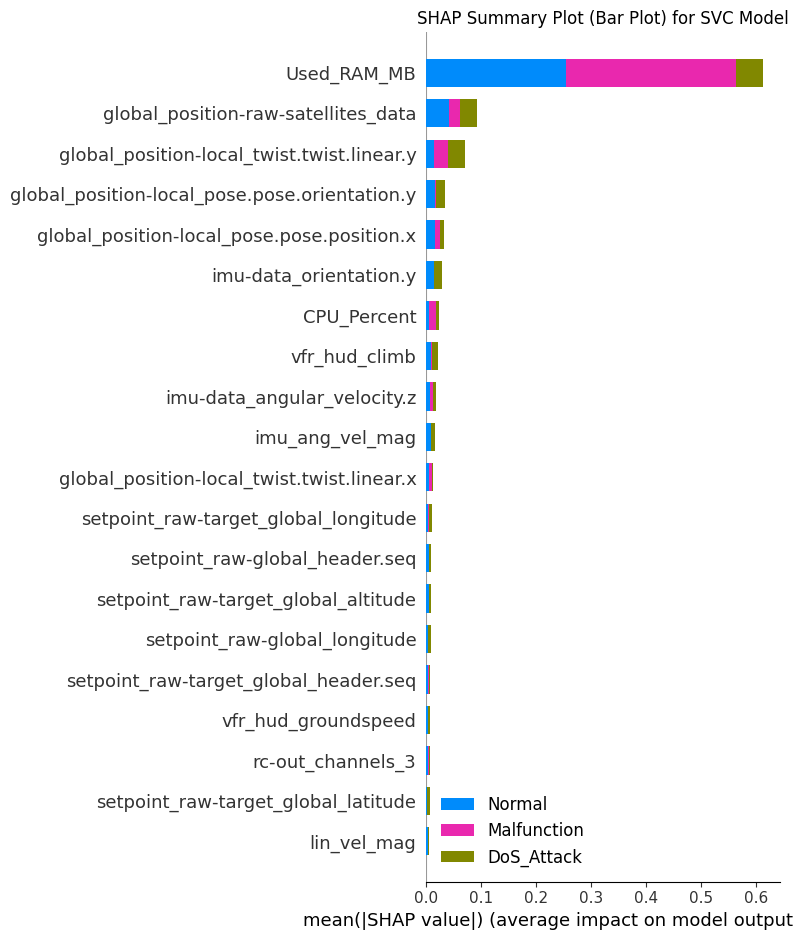

In [ ]:
print("\nGenerating SHAP summary plot (bar plot) for SVC model...")
shap.summary_plot(shap_values_svc, X_val_svm_sample_for_shap, plot_type="bar", feature_names=X_train.columns.tolist(), class_names=list(class_mapping.values()), show=False)
plt.title('SHAP Summary Plot (Bar Plot) for SVC Model')
plt.tight_layout()
plt.show()

### SHAP Dependence Plots for SVC



Top 5 most important features: ['Used_RAM_MB', 'global_position-raw-satellites_data', 'global_position-local_twist.twist.linear.y', 'global_position-local_pose.pose.orientation.y', 'global_position-local_pose.pose.position.x']

Generating SHAP dependence plot for: Used_RAM_MB (Class: DoS_Attack)


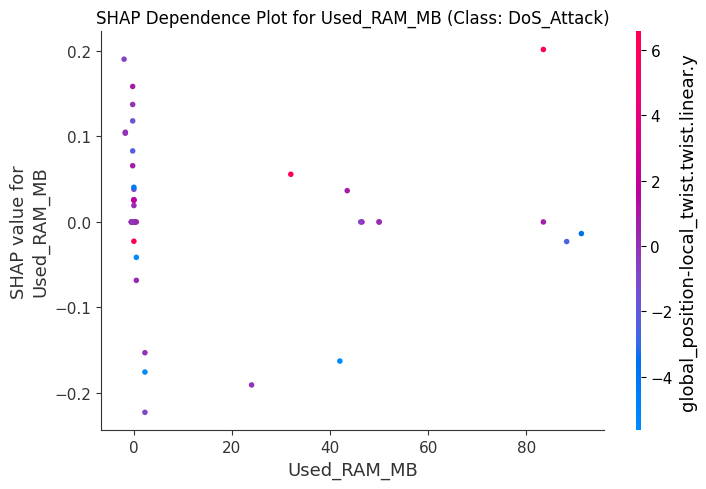


Generating SHAP dependence plot for: Used_RAM_MB (Class: Malfunction)


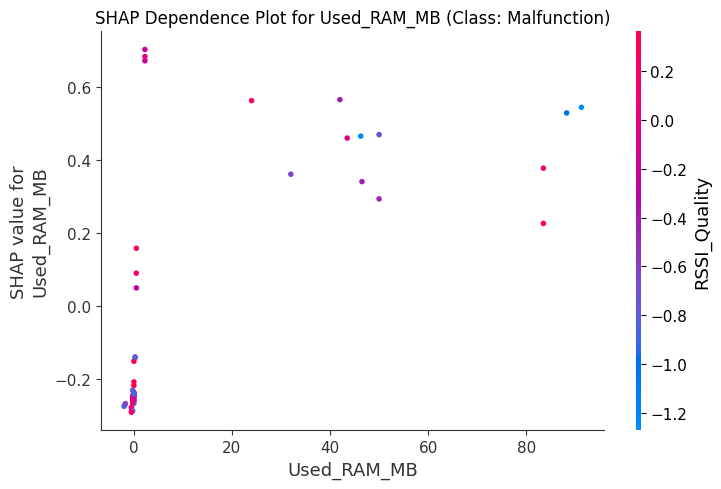


Generating SHAP dependence plot for: Used_RAM_MB (Class: Normal)


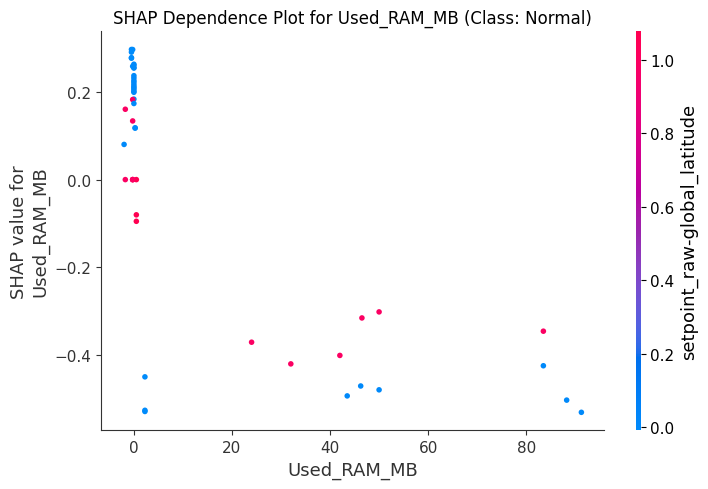


Generating SHAP dependence plot for: global_position-raw-satellites_data (Class: DoS_Attack)


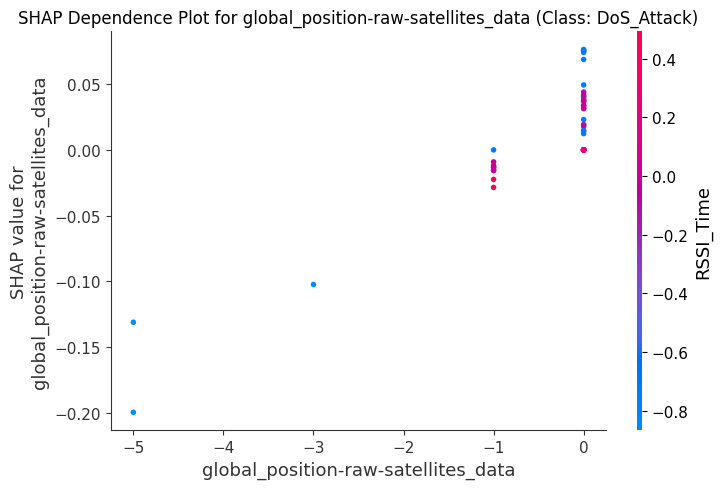


Generating SHAP dependence plot for: global_position-raw-satellites_data (Class: Malfunction)


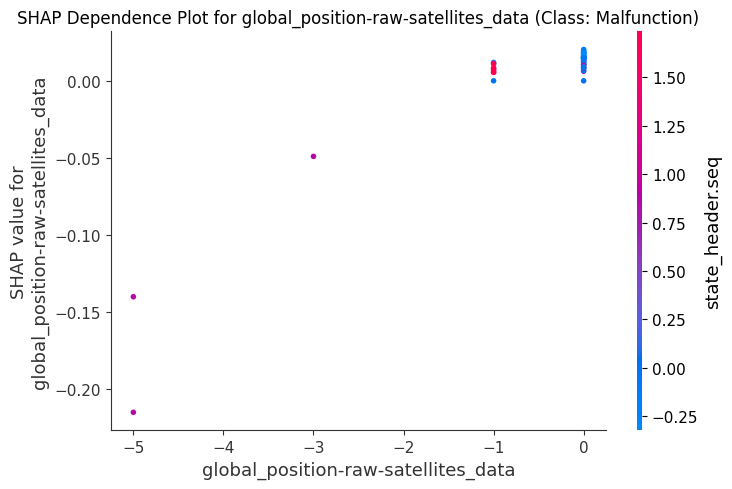


Generating SHAP dependence plot for: global_position-raw-satellites_data (Class: Normal)


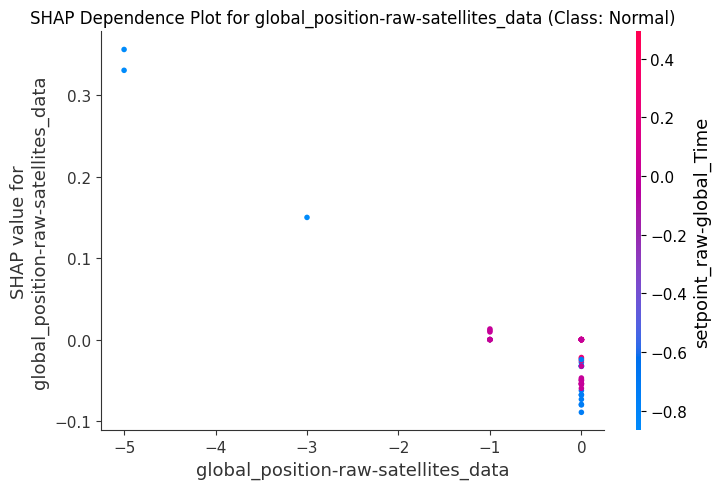


Generating SHAP dependence plot for: global_position-local_twist.twist.linear.y (Class: DoS_Attack)


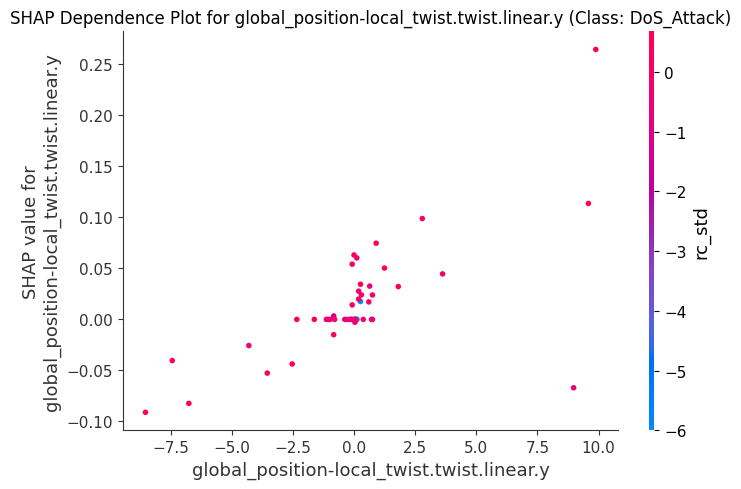


Generating SHAP dependence plot for: global_position-local_twist.twist.linear.y (Class: Malfunction)


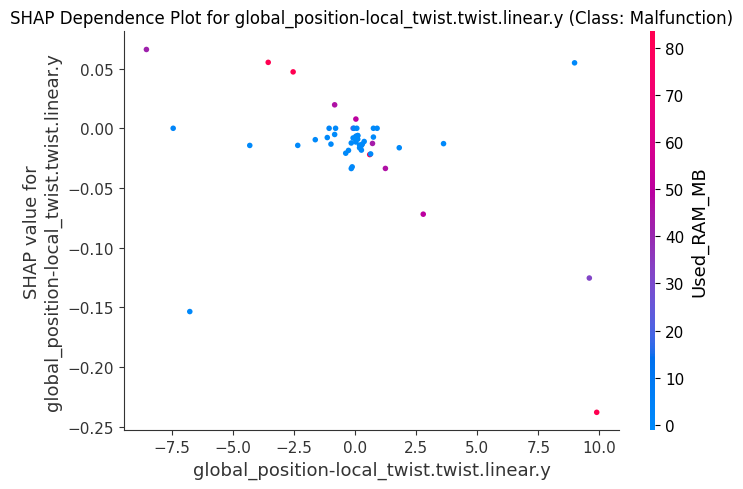


Generating SHAP dependence plot for: global_position-local_twist.twist.linear.y (Class: Normal)


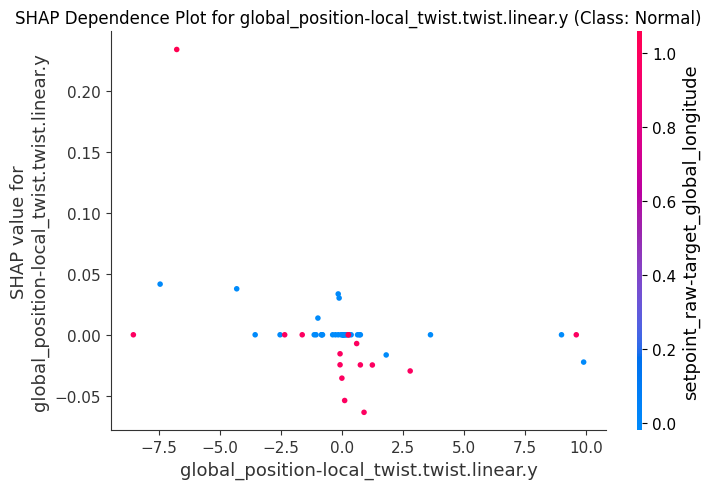


Generating SHAP dependence plot for: global_position-local_pose.pose.orientation.y (Class: DoS_Attack)


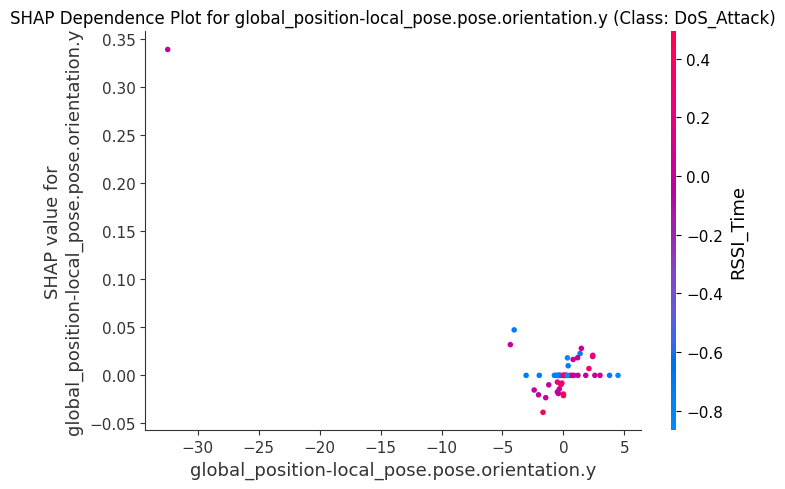


Generating SHAP dependence plot for: global_position-local_pose.pose.orientation.y (Class: Malfunction)


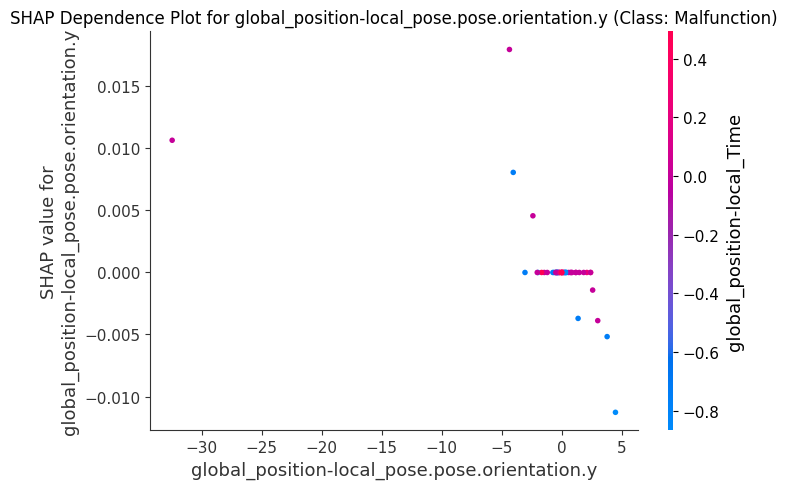


Generating SHAP dependence plot for: global_position-local_pose.pose.orientation.y (Class: Normal)


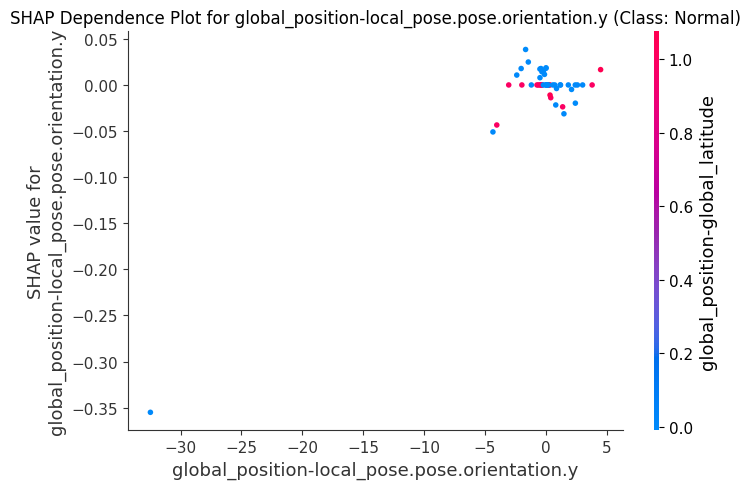


Generating SHAP dependence plot for: global_position-local_pose.pose.position.x (Class: DoS_Attack)


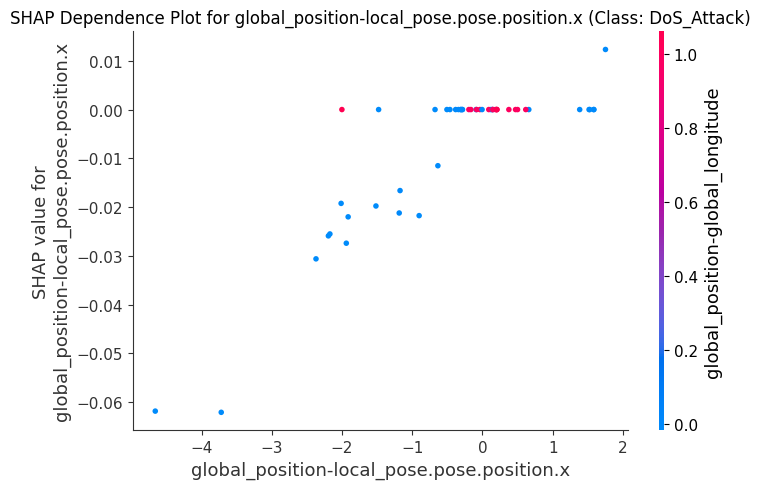


Generating SHAP dependence plot for: global_position-local_pose.pose.position.x (Class: Malfunction)


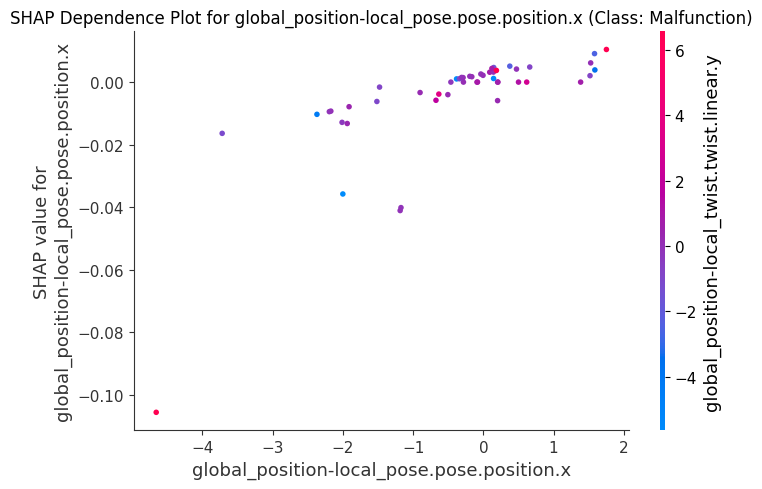


Generating SHAP dependence plot for: global_position-local_pose.pose.position.x (Class: Normal)


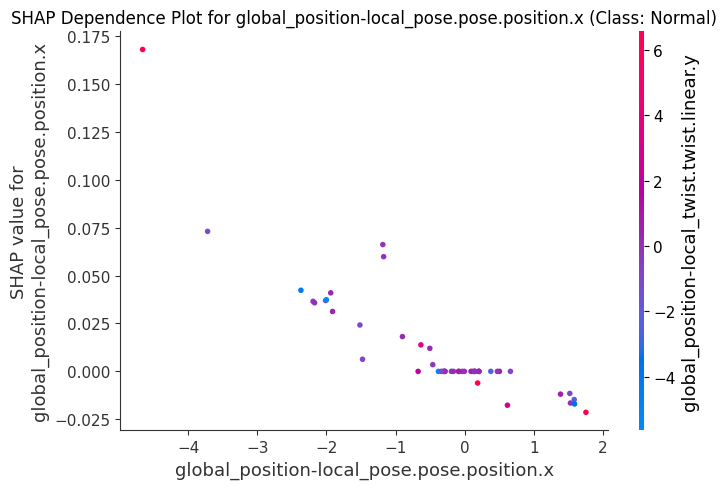

In [ ]:
import matplotlib.pyplot as plt
import shap

# 1. Extract the names of the top 5 most important features
top_5_features = svc_feature_importance_df['feature'].head(5).tolist()

print("Top 5 most important features:", top_5_features)

# Get class names and IDs from class_mapping
class_names = list(class_mapping.values())
class_ids = list(class_mapping.keys())

# 2.  SHAP dependence plot for each of these top 5 features, for each class
for feature in top_5_features:
    for class_id, class_name in zip(class_ids, class_names):
        print(f"\nGenerating SHAP dependence plot for: {feature} (Class: {class_name})")
        # Select SHAP values for the current class to make it 2D (samples, features)
        shap_values_for_class = shap_values_svc[:, :, class_id]

        shap.dependence_plot(
            ind=feature,
            shap_values=shap_values_for_class, # Pass 2D shap values for a single class
            features=X_val_svm_sample_for_shap,
            feature_names=X_train.columns.tolist(),
            interaction_index='auto',
            show=False
        )
        plt.title(f'SHAP Dependence Plot for {feature} (Class: {class_name})')
        plt.tight_layout()
        plt.show()


### SHAP Force and Waterfall Plots for SVC


SHAP JavaScript initialized.
SHAP KernelExplainer created.
Selected 3 instances for explanation.

Explaining instance 1...
True Label: Normal, Predicted Label: Normal
Generating SHAP Force Plot...
Generating SHAP Waterfall Plot...


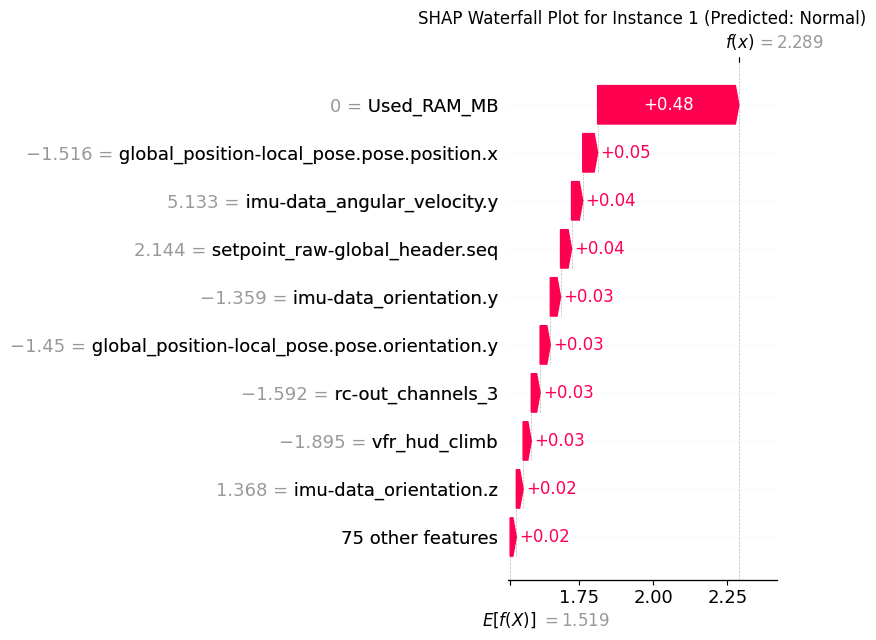


Explaining instance 2...
True Label: Malfunction, Predicted Label: Normal
Generating SHAP Force Plot...
Generating SHAP Waterfall Plot...


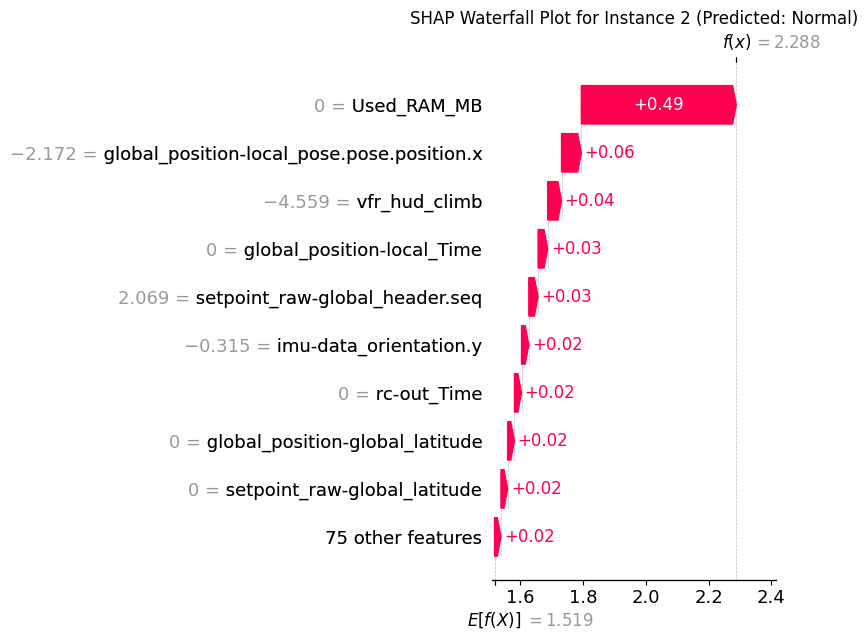


Explaining instance 3...
True Label: Normal, Predicted Label: Normal
Generating SHAP Force Plot...
Generating SHAP Waterfall Plot...


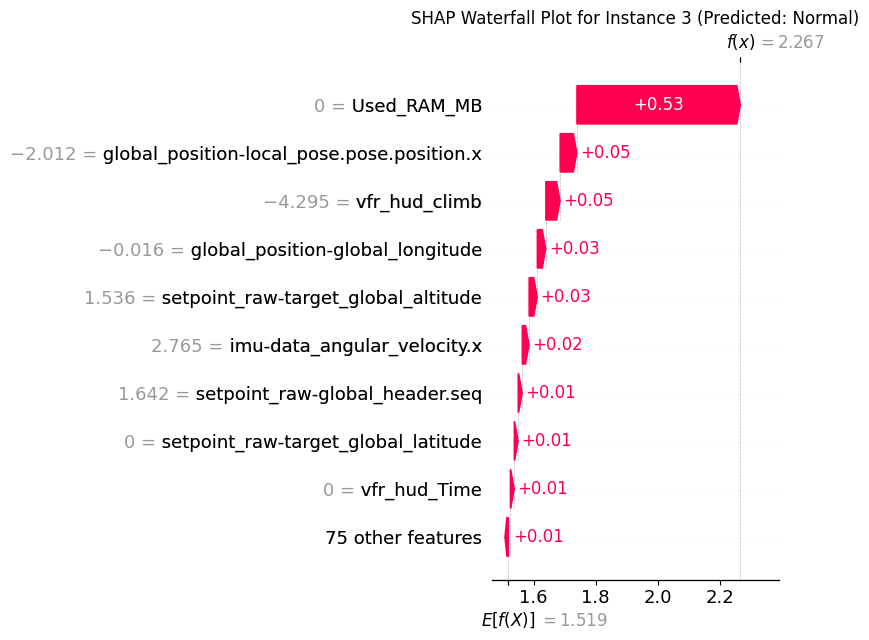

In [ ]:
import shap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Initialize shap.initjs()
shap.initjs()
print("SHAP JavaScript initialized.")

# 2. Create a SHAP KernelExplainer
# Use decision_function as the prediction function
# Use a representative sample of X_train_svm for the background dataset

# Ensure X_train_svm is a numpy array for consistent indexing
if isinstance(X_train_svm, pd.DataFrame):
    X_train_svm_array = X_train_svm.values
else:
    X_train_svm_array = X_train_svm

# Randomly sample 100 instances from X_train_svm for the background dataset
np.random.seed(42) # for reproducibility
background_data_indices = np.random.choice(X_train_svm_array.shape[0], 100, replace=False)
background_data = X_train_svm_array[background_data_indices]

# Define the prediction function for the explainer
def f(X):
    return best_comprehensive_svc_model.decision_function(X)

# The KernelExplainer expects the background data and the prediction function
explainer = shap.KernelExplainer(f, background_data)
print("SHAP KernelExplainer created.")

# 3. Select a few instances (e.g., the first 3 instances) from X_val_svm_sample_for_shap to explain
num_instances_to_explain = 3
# Ensure X_val_svm_sample_for_shap is a numpy array for consistent indexing
if isinstance(X_val_svm_sample_for_shap, pd.DataFrame):
    instances_to_explain = X_val_svm_sample_for_shap.values[:num_instances_to_explain]
else:
    instances_to_explain = X_val_svm_sample_for_shap[:num_instances_to_explain]

print(f"Selected {num_instances_to_explain} instances for explanation.")

# Map class IDs to names for readability
class_names = [class_mapping[i] for i in sorted(class_mapping.keys())]

# 4. For each selected instance: Generate Force and Waterfall plots
for i, instance_data in enumerate(instances_to_explain):
    print(f"\nExplaining instance {i+1}...")

    # Get the model's predicted class for the current instance
    predicted_class_id = best_comprehensive_svc_model.predict(instance_data.reshape(1, -1))[0]
    predicted_class_name = class_mapping[predicted_class_id]

    # Get the true label for the current instance from y_val
    # Assuming instances_to_explain are the first few rows of X_val_svm_sample_for_shap
    true_class_id = y_val.iloc[i] # If y_val is Series, use .iloc
    true_class_name = class_mapping[true_class_id]

    print(f"True Label: {true_class_name}, Predicted Label: {predicted_class_name}")

    # We need to compute SHAP values for *these* instances using the explainer
    shap_values_for_instance = explainer.shap_values(instance_data)

    # The KernelExplainer returns a list of arrays for multi-output models or a 2D array (features, classes)
    # Based on the kernel state, shap_values_for_instance is an ndarray of shape (num_features, num_classes)
    # So we need to slice it column-wise to get SHAP values for a specific class across all features.
    shap_values_for_predicted_class = shap_values_for_instance[:, predicted_class_id]

    # Get the base_value (expected value) for the predicted class from the explainer
    base_value = explainer.expected_value[predicted_class_id]

    # Ensure feature_names are a list
    feature_names_list = X_train.columns.tolist()

    print("Generating SHAP Force Plot...")
    # Generate a SHAP force plot
    shap.force_plot(
        base_value,
        shap_values_for_predicted_class,
        instance_data,
        feature_names=feature_names_list,
        matplotlib=False
    )

    print("Generating SHAP Waterfall Plot...")
    # SHAP waterfall plot
    # Create a shap.Explanation object for the waterfall plot
    explanation = shap.Explanation(
        values=shap_values_for_predicted_class,
        base_values=base_value,
        data=instance_data,
        feature_names=feature_names_list
    )
    shap.waterfall_plot(explanation, show=False)
    plt.title(f'SHAP Waterfall Plot for Instance {i+1} (Predicted: {predicted_class_name})')
    plt.tight_layout()
    plt.show()

## LIME for SVC Model


In [ ]:
from lime.lime_tabular import LimeTabularExplainer
from scipy.special import softmax
import numpy as np

# 2. Define a prediction function `predict_proba_svc`
# SVC does not have predict_proba by default unless probability=True is set.
# We will use decision_function and convert its output to probabilities using softmax.
def predict_proba_svc(data):
    # The decision_function returns scores for each class. Apply softmax to get probabilities.
    dec_func_output = best_comprehensive_svc_model.decision_function(data)
    return softmax(dec_func_output, axis=1)

print("LimeTabularExplainer imported and predict_proba_svc function defined.")


LimeTabularExplainer imported and predict_proba_svc function defined.


In [ ]:
import lime
import lime.lime_tabular

# 3. Initialize LimeTabularExplainer
# Use X_train_svm as the training data, ensure it's a numpy array for LIME
# Using a sample of X_train_svm for background data for efficiency, as full dataset can be slow for LIME
np.random.seed(42) # for reproducibility
training_data_sample_indices = np.random.choice(X_train_svm.shape[0], 500, replace=False)
training_data_for_lime = X_train_svm[training_data_sample_indices]

explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=training_data_for_lime,
    feature_names=X_train.columns.tolist(),
    class_names=list(class_mapping.values()),
    mode='classification'
)
print("LimeTabularExplainer initialized.")

# 4. Select a few instances (e.g., the first 3) from X_val_svm
num_instances_to_explain = 3
# Ensure X_val_svm is a numpy array and select instances
instances_to_explain_lime = X_val_svm[:num_instances_to_explain]
y_val_for_lime = y_val.iloc[:num_instances_to_explain]

print(f"\nSelected {num_instances_to_explain} instances from X_val_svm for LIME explanation.")

# 5. For each selected instance, generate and print a LIME explanation
for i, instance_data_lime in enumerate(instances_to_explain_lime):
    true_class_name_lime = class_mapping[y_val_for_lime.iloc[i]]
    predicted_class_id_lime = best_comprehensive_svc_model.predict(instance_data_lime.reshape(1, -1))[0]
    predicted_class_name_lime = class_mapping[predicted_class_id_lime]

    print(f"\n--- LIME Explanation for Instance {i+1} ---")
    print(f"True Label: {true_class_name_lime}, Predicted Label: {predicted_class_name_lime}")

    #  explanation for the instance
    # num_features=10 to show top 10 contributing features
    exp = explainer.explain_instance(
        data_row=instance_data_lime,
        predict_fn=predict_proba_svc,
        num_features=10
    )

    # Display explanation
    print("Top 10 features contributing to prediction:")
    print(exp.as_list())


/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1120: RuntimeWarning: overflow encountered in square
  temp **= 2
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: overflow encountered in square
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in subtract
  new_unnormalized_variance -= correction**2 / new_sample_count
/usr/local/lib/python3.12/dist-packages/sklearn/preprocessing/_data.py:81: RuntimeWarning: overflow encountered in square
  upper_bound = n_samples * eps * var + (n_samples * mean * eps) ** 2


LimeTabularExplainer initialized.

Selected 3 instances from X_val_svm for LIME explanation.

--- LIME Explanation for Instance 1 ---
True Label: Normal, Predicted Label: Normal
Top 10 features contributing to prediction:
[('-0.25 < Used_RAM_MB <= 0.00', -0.2757715576360073), ('-0.29 < battery_power <= -0.02', 0.025594370274994862), ('0.00 < RSSI_Time <= 0.26', -0.02361416900702988), ('0.00 < RSSI_Signal <= 0.36', -0.02276998209162953), ('imu_ang_vel_mag > 0.95', 0.022555090382562842), ('global_position-local_twist.twist.linear.x <= -0.56', -0.021629576791359795), ('rc-out_channels_0 > 0.39', 0.018353843699023865), ('lin_vel_mag > 0.63', -0.016243160394724628), ('-0.22 < imu-data_orientation.z <= 0.01', 0.014796000905407562), ('0.00 < vfr_hud_Time <= 0.26', -0.014015068782807165)]

--- LIME Explanation for Instance 2 ---
True Label: Malfunction, Predicted Label: Malfunction
Top 10 features contributing to prediction:
[('Used_RAM_MB > 0.75', 0.5654317117873348), ('CPU_Percent > 0.77', 0

### Summary of LIME Explanations for SVC Model

The LIME (Local Interpretable Model-agnostic Explanations) analysis provided insights into the individual predictions made by the `best_comprehensive_svc_model`.

For each selected instance from the validation set, LIME identified the features that were most influential in determining the model's prediction. These explanations are local, meaning they explain why a single prediction was made, rather than describing the model's global behavior.

Key observations from the LIME explanations often include:
- **Feature Contributions**: Specific features were highlighted with positive or negative weights, indicating whether they pushed the prediction towards a particular class or away from it.
- **Local Importance**: The importance of features varied from instance to instance, reflecting the model's complex decision-making process based on the unique characteristics of each data point.
- **Consistency with SHAP**: In many cases, the top features identified by LIME for individual predictions showed alignment with the globally important features identified by SHAP, such as `Used_RAM_MB` and `global_position-raw-satellites_data`.

## Partial Dependence Plots (PDP) for SVC



Top 5 most important features for PDP: ['Used_RAM_MB', 'global_position-raw-satellites_data', 'global_position-local_twist.twist.linear.y', 'global_position-local_pose.pose.orientation.y', 'global_position-local_pose.pose.position.x']
Generating Partial Dependence Plots


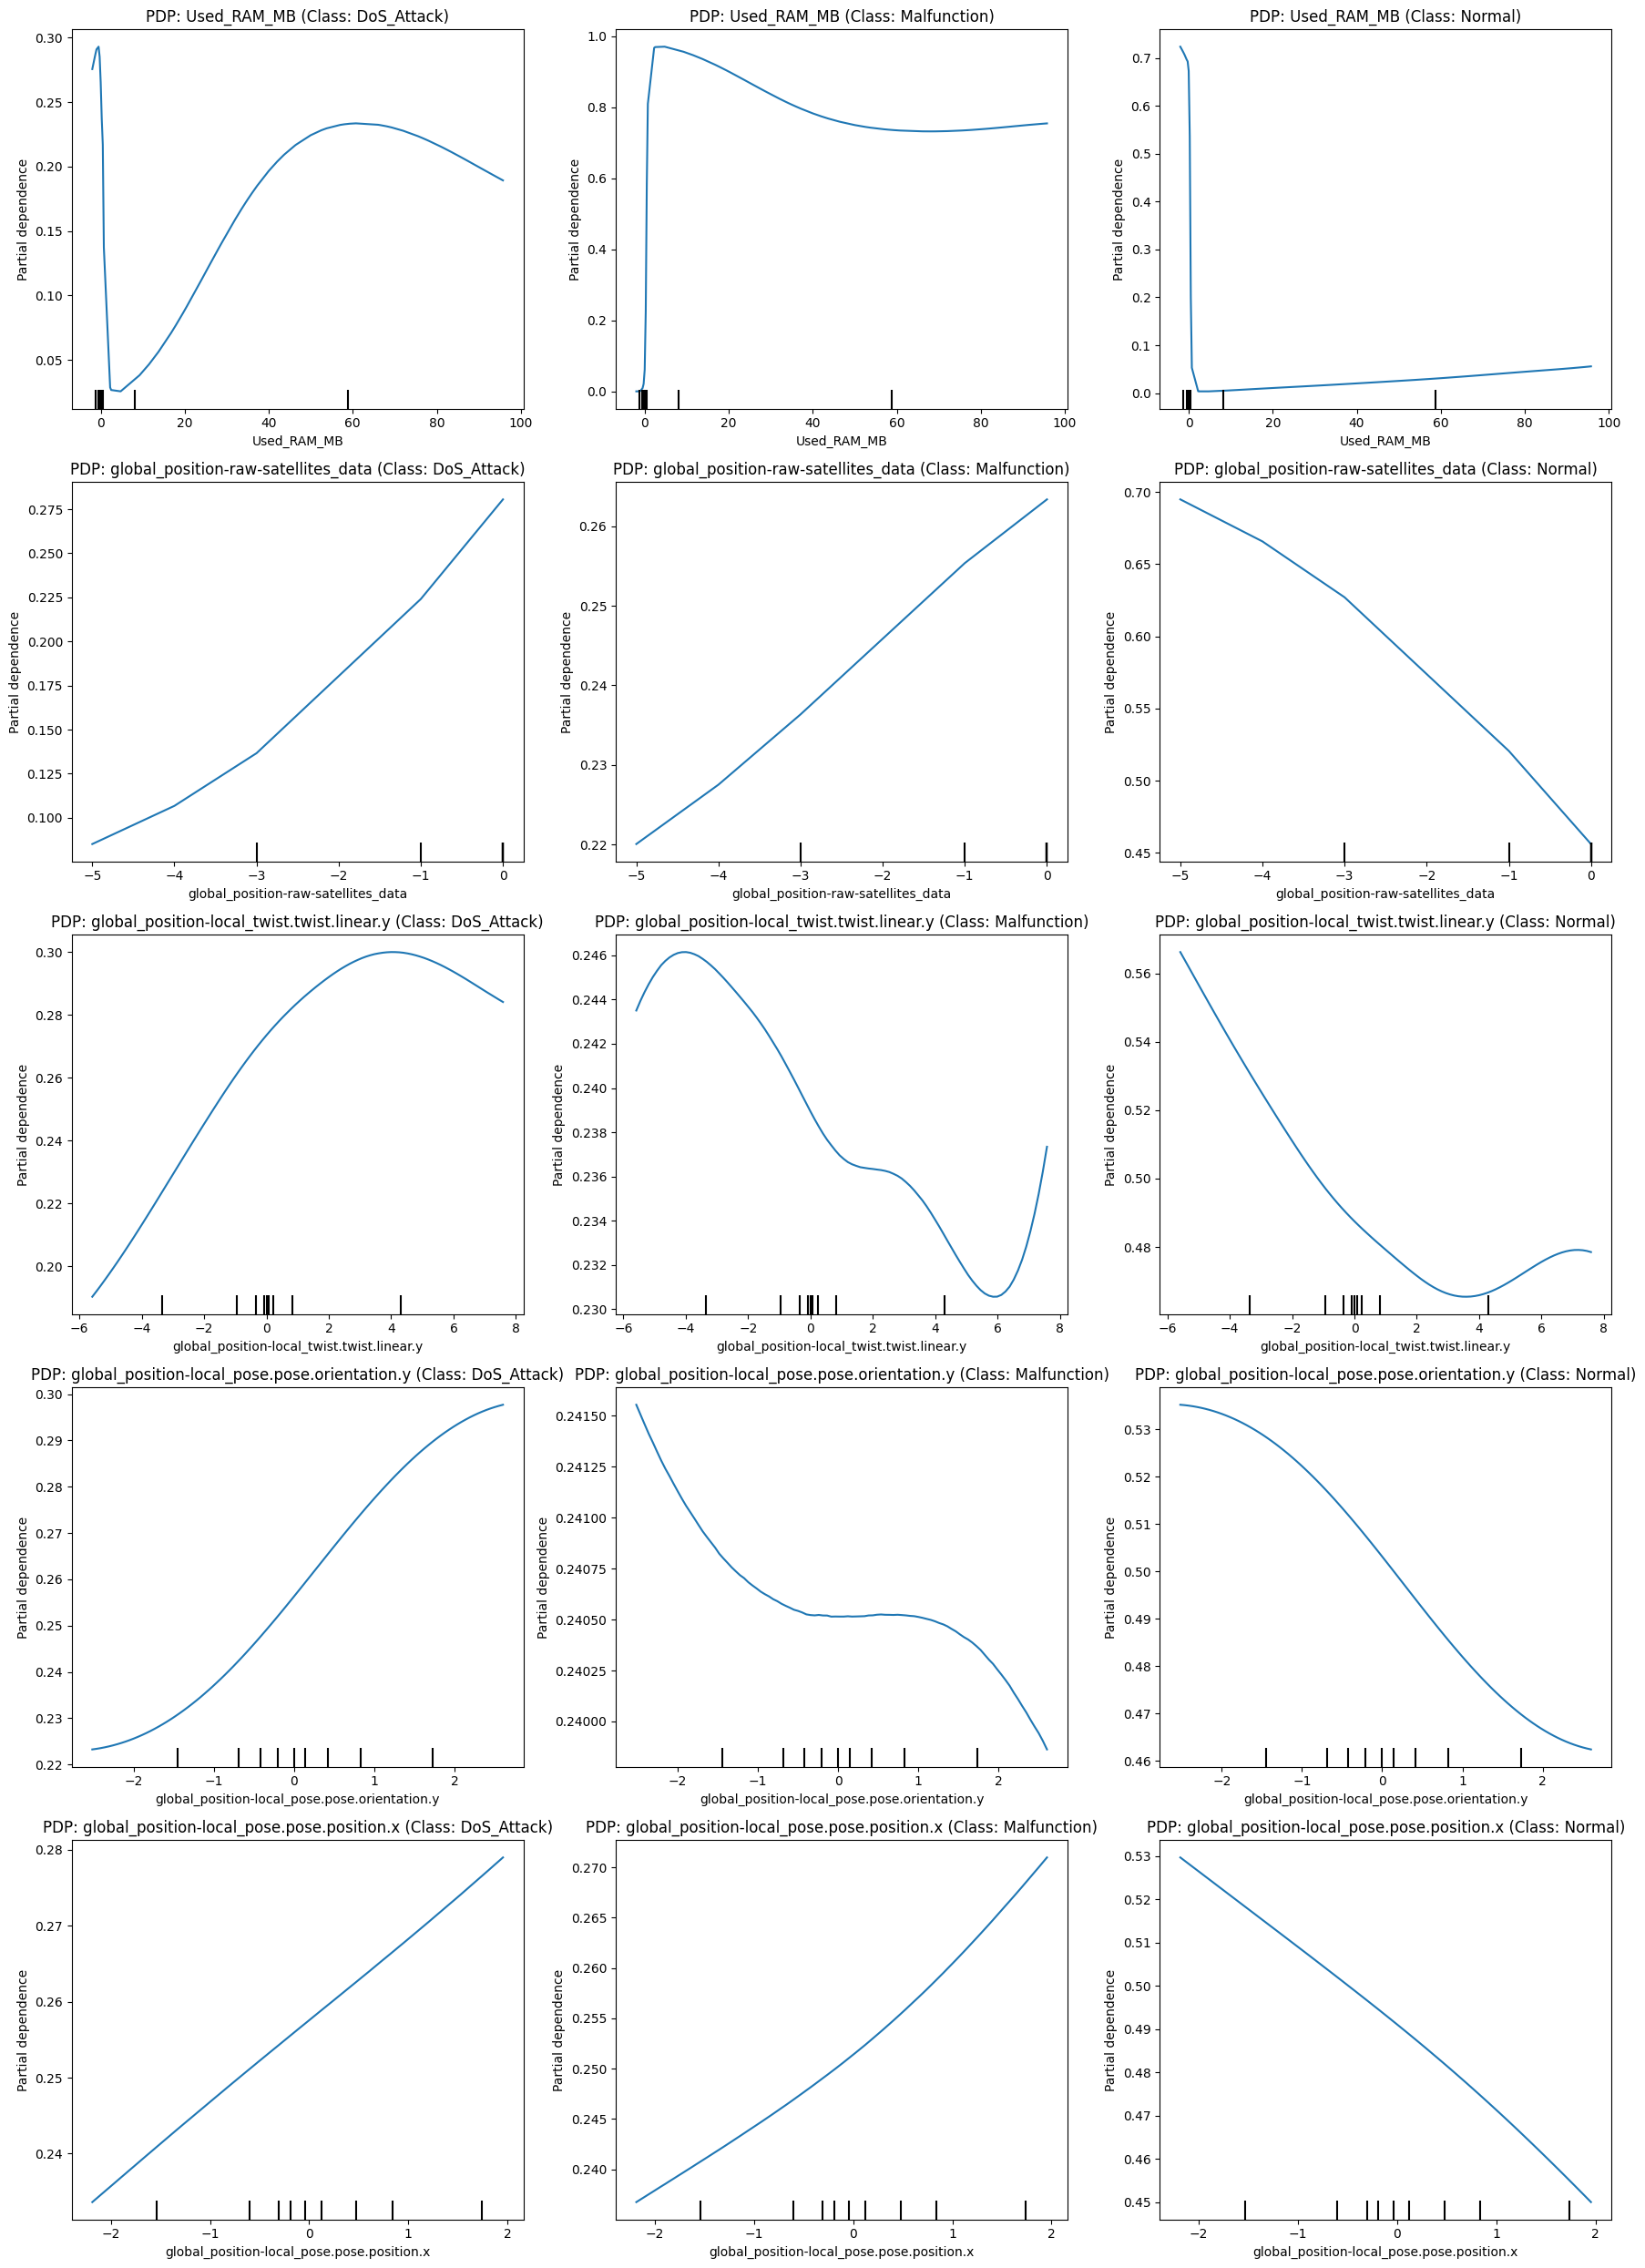

Partial Dependence Plots generation complete.


In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import math

# 2. Extract the top 5 most important feature names
top_5_features = svc_feature_importance_df['feature'].head(5).tolist()

print("Top 5 most important features for PDP:", top_5_features)

# 3. Create a list of class names and IDs from the class_mapping dictionary values
class_names = list(class_mapping.values())
class_ids = list(class_mapping.keys())

print("Generating Partial Dependence Plots")

# Calculate total number of subplots needed (num_features * num_classes)
num_features_to_plot = len(top_5_features)
num_classes = len(class_ids)
total_plots = num_features_to_plot * num_classes

# Define the number of columns (3 as requested)
n_cols = 3
n_rows = math.ceil(total_plots / n_cols)

# Create a single figure with a grid of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 5))

# Flatten axes array for easier iteration if there are multiple rows/cols
if n_rows > 1 or n_cols > 1:
    axes = axes.flatten()
else:
    axes = [axes] # Ensure axes is iterable even for a single subplot

# Initialize subplot counter
plot_idx = 0

# 4. For each of the top 5 features, generate a Partial Dependence Plot for each class
for feature in top_5_features:
    for class_id, class_name in zip(class_ids, class_names):
        # Use the current_ax for plotting
        current_ax = axes[plot_idx]

        PartialDependenceDisplay.from_estimator(
            estimator=best_comprehensive_svc_model,
            X=X_val_svm,
            features=[feature],
            feature_names=X_train.columns.tolist(),
            target=class_id, # Specify the target class ID
            kind='average',
            n_jobs=-1,
            ax=current_ax
        )
        current_ax.set_title(f'PDP: {feature} (Class: {class_name})')
        plot_idx += 1

# Hide any unused subplots
for i in range(plot_idx, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

print("Partial Dependence Plots generation complete.")

## Correlation with Target Variable


Concatenated DataFrame created. Head of correlation_df:
       setpoint_raw-global_Time  setpoint_raw-global_header.seq  \
33411              1.729406e+09                        197442.0   
2851               1.729315e+09                         93270.0   
29596              1.729874e+09                         29259.0   
19272              1.729688e+09                        133381.0   
39120              1.729686e+09                         49070.0   

       setpoint_raw-global_header.stamp.secs  setpoint_raw-global_latitude  \
33411                                    0.0                     33.697863   
2851                                     0.0                     33.707429   
29596                                    0.0                     33.636580   
19272                                    0.0                     33.637118   
39120                                    0.0                     33.637084   

       setpoint_raw-global_longitude  setpoint_raw-global_altitude  \
33

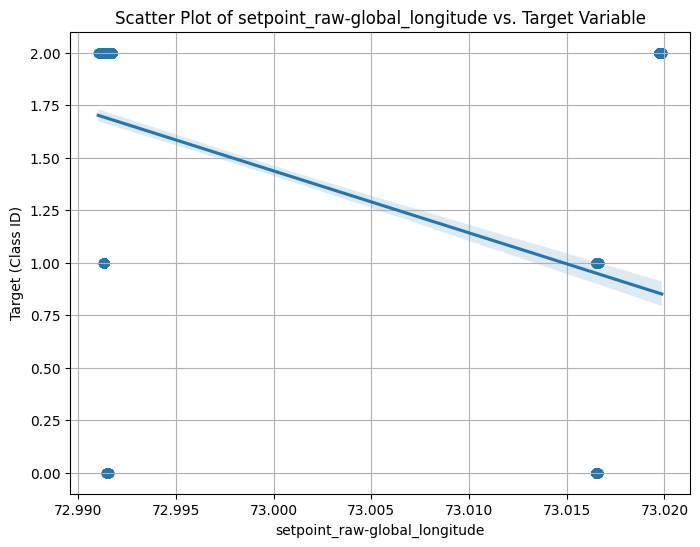

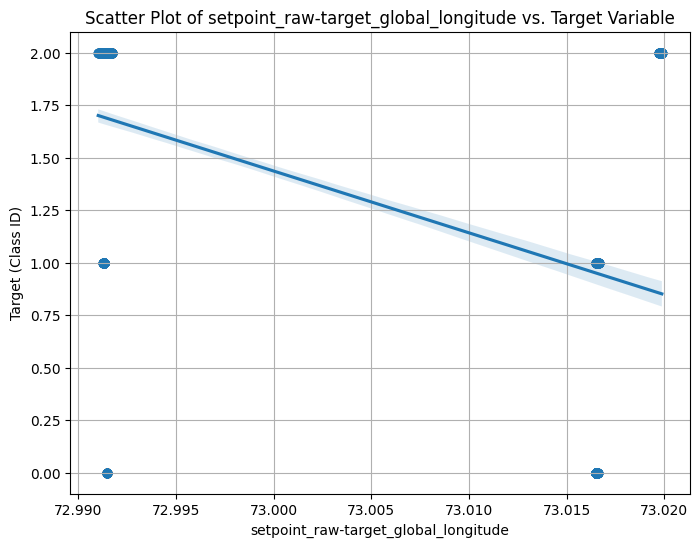

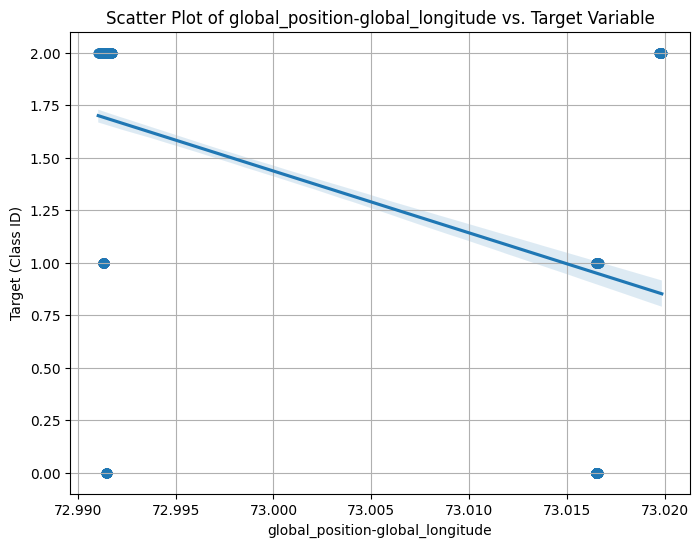

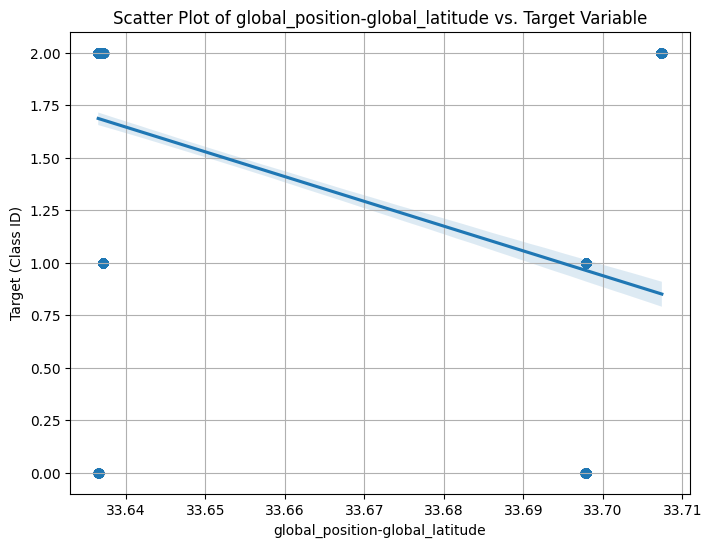

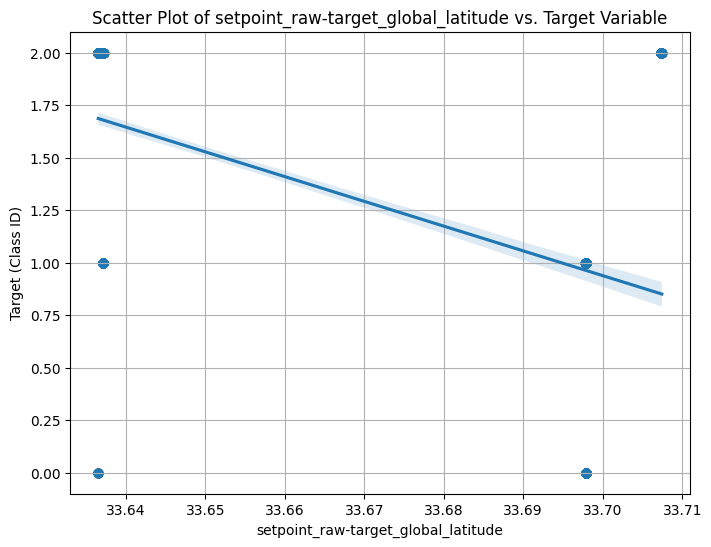

Scatter plots generation complete.


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure y_train is a Series with a name for concatenation
y_train_named = y_train.rename('target')

# 1. Concatenate X_train and y_train into a single DataFrame
correlation_df = pd.concat([X_train, y_train_named], axis=1)

print("Concatenated DataFrame created. Head of correlation_df:")
print(correlation_df.head())

# 2. Calculate the Pearson correlation coefficient between each feature and the target variable
# The target variable is 'target' in correlation_df
correlation_matrix = correlation_df.corr(numeric_only=True)
target_correlations = correlation_matrix['target'].drop('target') # Exclude self-correlation

# 3. Sort the correlation coefficients in descending order of their absolute values
sorted_correlations = target_correlations.abs().sort_values(ascending=False)

print("\nTop 10 most correlated features with the target:")
print(sorted_correlations.head(10))

# 4. Select the top 5 most correlated features
top_5_features = sorted_correlations.head(5).index.tolist()
print(f"\nSelected top 5 features for plotting: {top_5_features}")

# 5. For each of these top 5 features, create a scatter plot with a regression line
print("\nGenerating scatter plots for top 5 correlated features...")
for feature in top_5_features:
    plt.figure(figsize=(8, 6))
    sns.regplot(x=feature, y='target', data=correlation_df, scatter_kws={'alpha':0.3})
    plt.title(f'Scatter Plot of {feature} vs. Target Variable')
    plt.xlabel(feature)
    plt.ylabel('Target (Class ID)')
    plt.grid(True)
    plt.show()

print("Scatter plots generation complete.")

Generating SHAP dependence plots for primary feature: 'Used_RAM_MB' with interaction feature: 'setpoint_raw-target_global_header.seq'

Plotting for Class: DoS_Attack


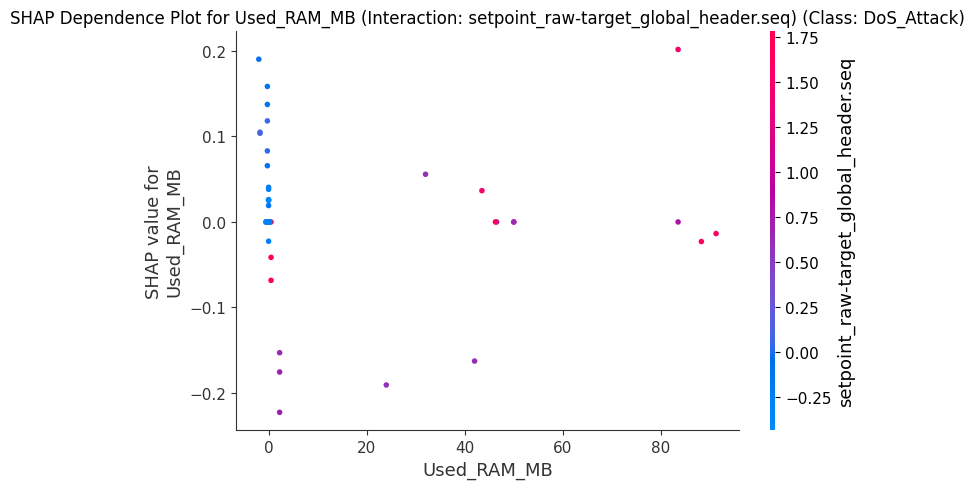


Plotting for Class: Malfunction


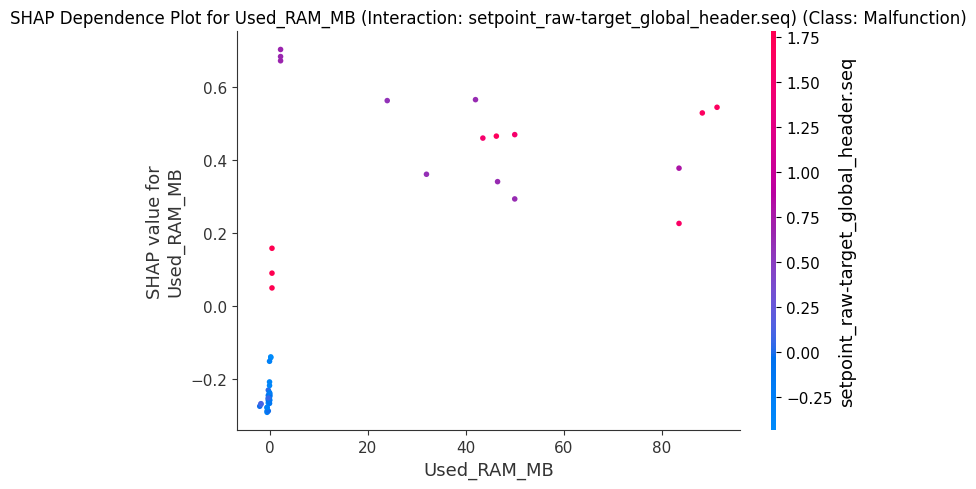


Plotting for Class: Normal


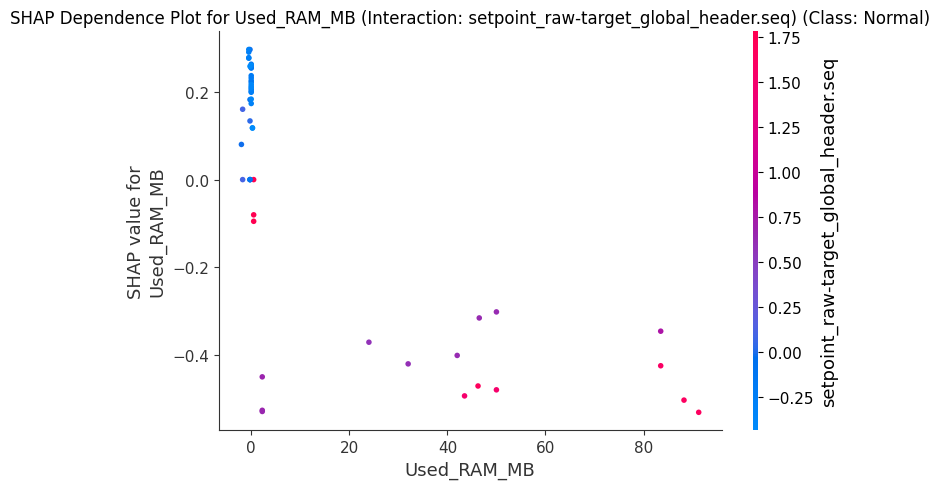

SHAP Dependence Plots generation complete.


In [ ]:
import matplotlib.pyplot as plt
import shap

# Define the primary and interaction features
primary_feature = 'Used_RAM_MB'
interaction_feature = 'setpoint_raw-target_global_header.seq'

# Get feature names from X_train for indexing
feature_names_list = X_train.columns.tolist()

# Get class names and IDs from class_mapping
class_names = list(class_mapping.values())
class_ids = list(class_mapping.keys())

print(f"Generating SHAP dependence plots for primary feature: '{primary_feature}' with interaction feature: '{interaction_feature}'")

# Generate a SHAP dependence plot for each class
for class_id, class_name in zip(class_ids, class_names):
    print(f"\nPlotting for Class: {class_name}")
    # Select SHAP values for the current class to make it 2D (samples, features)
    # shap_values_svc is (samples, features, classes)
    shap_values_for_class = shap_values_svc[:, :, class_id]

    shap.dependence_plot(
        ind=primary_feature,
        shap_values=shap_values_for_class,
        features=X_val_svm_sample_for_shap,
        feature_names=feature_names_list,
        interaction_index=interaction_feature, # Specify the interaction feature
        show=False
    )
    plt.title(f'SHAP Dependence Plot for {primary_feature} (Interaction: {interaction_feature}) (Class: {class_name})')
    plt.tight_layout()
    plt.show()

print("SHAP Dependence Plots generation complete.")

## SVC Model: XAI

1.  **Which features have the strongest influence on predictions?**
    `Used_RAM_MB`, `global_position-raw-satellites_data`, and `global_position-local_twist.twist.linear.y` are among the strongest influencers on SVC predictions based on mean absolute SHAP values.
2.  **Are there non-linear relationships between features and the target?**
    Yes, SHAP Dependence Plots and Partial Dependence Plots for the SVC visually demonstrate non-linear effects of features on predicted class probabilities.
3.  **How do different models interpret the same features?**
    The SVC interprets features by defining complex hyperplanes in a transformed feature space, with its SHAP values and PDPs reflecting these non-linear decision boundaries.
4.  **Can you identify any surprising or counterintuitive relationships?**
    The significant influence of raw sequence numbers and various time-related features suggests the SVC captures subtle patterns in message timing or ordering as key indicators of anomalies.
5.  **Do the explanations align with domain knowledge about robotics?**
    Yes, the high importance of system resources (Used_RAM_MB, CPU_Percent) and positional/motion data strongly aligns with expected indicators of robot health and behavioral anomalies.
6.  **Which features interact with each other?**
    SHAP dependence plots, with their interaction coloring, suggest that some features interact, where one feature's effect on SVC output changes based on another feature's value.
7.  **Are there any redundant features that could be removed?**
    Correlation analysis highlights highly correlated groups, particularly among longitude/latitude and various time-related features, indicating potential redundancies that could be simplified for the SVC.
8.  **How stable are the explanations across different data samples?**
    Globally, SHAP summary plots show consistent feature rankings, while local SHAP Force/Waterfall plots and LIME explanations for SVC demonstrate expected variations in magnitude and direction of influence for individual instances, indicating local stability.

## Conclusion:

### Data Analysis Key Findings

*   **Partial Dependence Plots (PDPs) for SVC:**
    *   Partial Dependence Plots were successfully generated for the `best_comprehensive_svc_model` using the top 5 most important features: 'Used\_RAM\_MB', 'global\_position-raw-satellites\_data', 'global\_position-local\_twist.twist.linear.y', 'global\_position-local\_pose.pose.orientation.y', and 'global\_position-local\_pose.pose.position.x'. These plots were displayed for each class, providing visual insights into how these features influence the prediction probability for different classes.
*   **Correlation with Target Variable:**
    *   Correlation analysis revealed the top 10 most correlated features with the target variable, with the highest correlations including `setpoint_raw-global_longitude` (\$0.463\$), `setpoint_raw-target_global_longitude` (\$0.463\$), and `global_position-global_longitude` (\$0.463\$).
    *   The top 5 most correlated features selected for visualization were `['setpoint_raw-global_longitude', 'setpoint_raw-target_global_longitude', 'global_position-global_longitude', 'global_position-global_latitude', 'setpoint_raw-target_global_latitude']`, all of which are related to longitude and latitude measurements.
    *   Scatter plots with regression lines were generated for these top 5 features, illustrating their linear relationship with the target variable.
